**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_1_1_)    
      - [Importing Python Libraries](#toc1_1_1_1_)    
      - [Loading Clean Dataset](#toc1_1_1_2_)    
    - [Number of Ratings](#toc1_1_2_)    
    - [Average Rating](#toc1_1_3_)    
    - [Target column](#toc1_1_4_)    
    - [Product Videos and Images](#toc1_1_5_)    
    - [Dealing with product title, description and feature columns](#toc1_1_6_)    
      - [Tokenizing Product titles and descriptions](#toc1_1_6_1_)    
      - [Product title length](#toc1_1_6_2_)    
    - [Dealing with store column](#toc1_1_7_)    
    - [Product Age](#toc1_1_8_)    
    - [Price column](#toc1_1_9_)    
    - [ Sub_categories and Department columns](#toc1_1_10_)    
      - [Aggregating ratings per combined-category](#toc1_1_10_1_)    
      - [Checking Department column](#toc1_1_10_2_)    
    - [Pickling final dataframe](#toc1_1_11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Introduction](#toc0_)

In this notebook, we perform pre-processing on different columns in the cleaned meta dataset to prepare the data for modeling. We also explore various opportunities of feature engineering and analyze their trends with respect to the target variable.

#### <a id='toc1_1_1_1_'></a>[Importing Python Libraries](#toc0_)

Importing necessary libraries for data pre-processing

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS,TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import string
import spacy
import unicodedata

# Ignore all warnings to avoid cluttering the output
import warnings
warnings.filterwarnings("ignore")

In [44]:
#Useful settings

plt.rcParams['figure.figsize'] = (8.0, 6.0) # set matplotlib global settings eg. figsize
sns.set_style("white")                   #Setting grid style in seaborn

#### <a id='toc1_1_1_2_'></a>[Loading Clean Dataset](#toc0_)

In [45]:
# Here we load the pickled combined DataFrame which has undergone basic cleaning 
meta_df = pd.read_pickle('../data/meta_sample_handmade.pkl')
meta_df.head()

,main_category,title,average_rating,rating_number,features,description_product,price,images,videos_product,store,...,sub_category_4,combined_category,Package Dimensions,orig_department,date_first_available,package_weight_ounces,package_length_inches,package_width_inches,package_height_inches,department
0,Handmade,Sterling Silver Hammered Ear Cuff,4.4,243,"[Solid Sterling Silver, Artisan Handcrafted, C...",[This simple ear cuff is made with solid Sterl...,24.00,[{'thumb': 'https://m.media-amazon.com/images/...,[],Twisted Designs Jewelry,...,NaN,Jewelry Earrings Ear Cuff,3.62 x 2.05 x 0.83 inches; 0.46 Ounces,unisex-adult,2015-10-27,0.46,3.62,2.05,0.83,unisex
1,Handmade,Witch Cigarette Case Business Card ID Holder W...,5.0,1,[],[This silver-tone metal case can be used as a ...,12.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Generic,...,Cigarette Cases,Clothing Shoes & Accessories Luggage Travel Ge...,NaN,unisex-adult,2018-01-10,NaN,NaN,NaN,NaN,unisex
2,Handmade,"Humorous Cat Wall Art - Decor for Home, Office...",4.5,108,[8x10 UNFRAMED PRINTS - NOT Canvas or Tin Sign...,[8x10 UNFRAMED Prints],12.95,[{'thumb': 'https://m.media-amazon.com/images/...,[],YELLOWBIRD ART & DESIGN,...,NaN,Home & Kitchen Artwork Prints,11.2 x 8.8 x 0.2 inches; 3.21 Ounces,NaN,2019-11-05,3.21,11.20,8.80,0.20,NaN
3,Handmade,Whiskey Glasses by Black Lantern – Floral Whis...,4.4,11,[PREMIUM GLASSWARE READY TO GIFT - Our glasses...,[],31.00,[{'thumb': 'https://m.media-amazon.com/images/...,[],Black Lantern,...,Glassware,Home & Kitchen Dining Tableware Glassware Tumb...,9 x 7 x 5 inches,NaN,2016-01-26,NaN,9.00,7.00,5.00,NaN
4,Handmade,LOVE Dog Paw Print Heart Sticker Decal Compati...,4.1,3,[],"[Decal Size: 1"" Tall X 3.2"" Wide Die cut out o...",3.99,[{'thumb': 'https://m.media-amazon.com/images/...,[],Generic,...,NaN,Electronics Accessories Laptop Skins & Decals,NaN,Womens,2016-11-14,NaN,NaN,NaN,NaN,women


In [46]:
#While these columns had only been retained for reference earlier, they are redundant and will be dropped from further analysis 
meta_df.drop(columns=['categories','details','orig_department','main_category','Package Dimensions',
                      'package_weight_ounces','package_length_inches','package_width_inches','package_height_inches' ],inplace=True)


In [47]:
#Checking the columns with data type as object

meta_df_cat = meta_df.select_dtypes(include="O")

print(f'The categorical columns in the combined dataset are {meta_df_cat.columns.tolist()}.')


The categorical columns in the combined dataset are ['title', 'features', 'description_product', 'images', 'videos_product', 'store', 'parent_asin', 'sub_category_1', 'sub_category_2', 'sub_category_3', 'sub_category_4', 'combined_category', 'department'].


### <a id='toc1_1_2_'></a>[Number of Ratings](#toc0_)

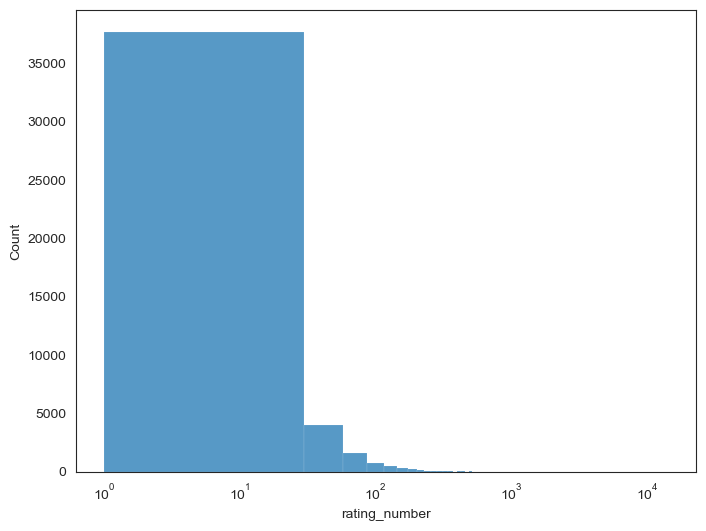

In [48]:
sns.histplot(x='rating_number', data=meta_df,bins=500)
plt.xscale('log')
plt.show()

In [49]:
meta_df['rating_number'].describe()

count    46165.000000
mean        29.381783
std        137.742687
min          1.000000
25%          2.000000
50%          6.000000
75%         20.000000
max      14235.000000
Name: rating_number, dtype: float64

Most of the products have only 1 rating indicating that their average rating is not a reliable indicator of customer satisfaction. We only filter products with atleast 2 ratings as that still allows us to use atleast 75 percent of the data.

In [50]:
meta_df = meta_df[meta_df['rating_number'] >1]
meta_df = meta_df.reset_index(drop=True)
meta_df.shape

(38154, 17)

### <a id='toc1_1_3_'></a>[Average Rating](#toc0_)

In [51]:
meta_df['average_rating'].describe()

count    38154.000000
mean         4.482319
std          0.542383
min          1.000000
25%          4.200000
50%          4.600000
75%          5.000000
max          5.000000
Name: average_rating, dtype: float64

In [52]:
meta_df['average_rating'].value_counts(normalize=True).head()

average_rating
5.0    0.267076
4.7    0.085705
4.6    0.083268
4.5    0.076270
4.8    0.073439
Name: proportion, dtype: float64

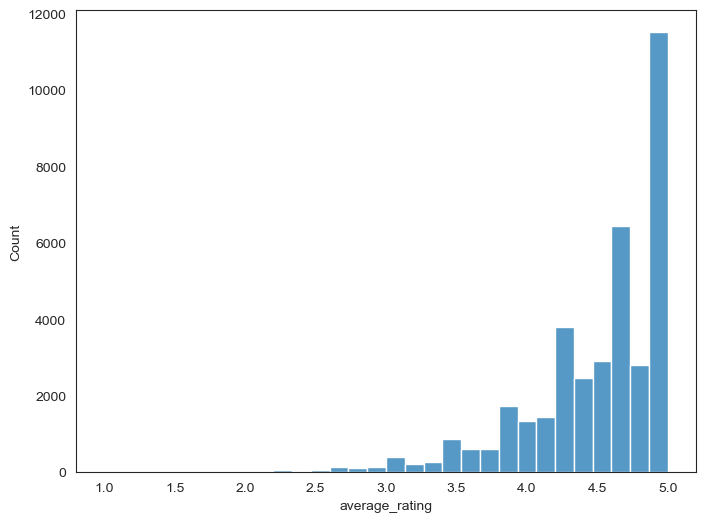

In [53]:
sns.histplot(x='average_rating', data=meta_df,bins=30)
plt.show()

Again, we notice that average ratings are heavily skewed towards perfect 5 star ratings.

### <a id='toc1_1_4_'></a>[Target column](#toc0_)

In this section, we create the target variable - `is_popular` for our binary classification problem of predicting product popularity.

We saw that - 
- Both `average_rating` and `rating_number` exhibit significant right-skew.
- Most products have few ratings, while a small fraction have thousands.

**Popularity Paradox**:

While we could use raw 'average rating' as a proxy for product's popularity, it raises the question -  

*Should a 5-star product with 1 rating be ranked higher than a 4.9-star product with 1000 ratings?*

Since raw averages fail to account for rating reliability, we consider Bayesian Rating to address this issue:

**Bayesian Rating** 

$$
\text{Adjusted Rating} = \frac{(\text{avg rating} \times \text{count of ratings}) + (\text{global\_avg} \times \text{trust\_threshold})}{\text{count of ratings} + \text{trust\_threshold}}
$$

**Variables**:

| Term                | Description                                                                  |
|---------------------|------------------------------------------------------------------------------|
| **Product Avg**     | The product’s current average rating.                                       |
| **Rating Count**    | The number of ratings the product has received.                             |
| **Global Avg**      | The average rating across *all* products in the dataset (4.49).            |
| **Trust Threshold** | The minimum number of ratings needed to "trust" the score (75% → 20 reviews). |

---

**Why This Works**  

The formula applies a weighted average between the product's observed ratings and a prior belief. As the number of ratings increases, the weight shifts toward the product’s actual average. On the other hand, it shrinks extreme scores (e.g., a 5.0 rating from only 2 reviews) toward the global average. 

This method improves upon simple weighted averages by handling sparse data effectively and automatically downweighting extreme values from low-count products. We set the trust threshold at the 75th percentile of rating counts (20 reviews), ensuring it represents a moderately reviewed product in the dataset.   

In [54]:
#Implementation of Bayesian Average
C = meta_df['average_rating'].mean()  # Global average 
m = meta_df['rating_number'].quantile(0.75)  # Trust threshold

# Bayesian Average Calculation
meta_df['bayesian_rating'] = (
    (meta_df['rating_number'] * meta_df['average_rating']) + (C * m)
) / (meta_df['rating_number'] + m)

meta_df['bayesian_rating'].describe()

count    38154.000000
mean         4.478005
std          0.145651
min          3.228049
25%          4.405340
50%          4.517429
75%          4.565245
max          4.923524
Name: bayesian_rating, dtype: float64

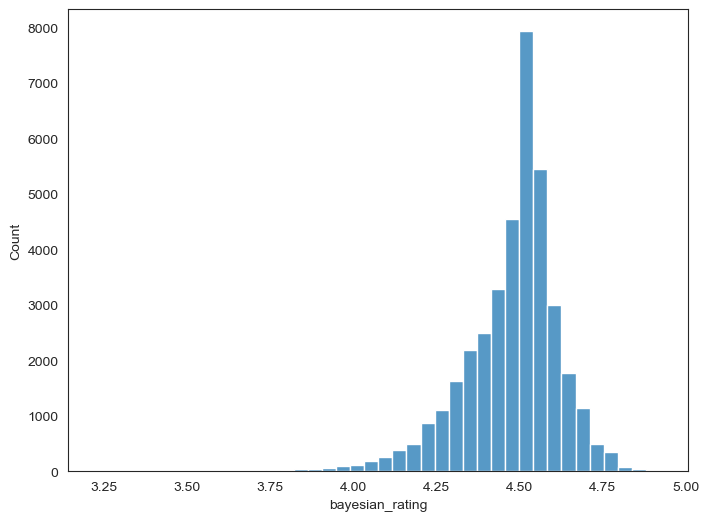

In [55]:
sns.histplot(x='bayesian_rating', data=meta_df,bins=40)
plt.show()

  After applying Bayesian adjustment, the distribution of `bayesian_rating` appears more normally distributed compared to the previously right-skewed distributions of `rating_number` and `average_rating`.  

This is because the Bayesian adjustment shrinks ratings with low counts toward the global average, reducing the influence of outliers (e.g., products with a perfect 5.0 rating from just a few reviews). This smoothing ensures that products with fewer ratings are not over-represented in the extremes. Furthermore, a normal-like distribution reduces the risk of models being biased toward extreme values. 

In [56]:
# now create a binary target variable:

# Median-based threshold
threshold = meta_df['bayesian_rating'].median()  

# Binary target column
meta_df['is_popular'] = (meta_df['bayesian_rating'] >= threshold).astype(int)

# Check class balance
print(meta_df['is_popular'].value_counts(normalize=True))

is_popular
1    0.505556
0    0.494444
Name: proportion, dtype: float64


To classify product popularity, we create a binary target variable based on the median Bayesian rating. Products with a Bayesian rating greater than or equal to the median are labeled as `1` (popular), while the rest are labeled as `0` (not popular). This approach ensures a balanced class distribution - approximately 50-50 split of the data.

### <a id='toc1_1_5_'></a>[Product Videos and Images](#toc0_)

While I will not be using the images directly in my analysis, it would be interesting to see if products that are usually accompanied by more images and videos from the seller tend to get higher scores.

In [57]:
#Images and Videos are stored in lists
meta_df[['images','videos_product']].head()

,images,videos_product
0,[{'thumb': 'https://m.media-amazon.com/images/...,[]
1,[{'thumb': 'https://m.media-amazon.com/images/...,[]
2,[{'thumb': 'https://m.media-amazon.com/images/...,[]
3,[{'thumb': 'https://m.media-amazon.com/images/...,[]
4,[{'thumb': 'https://m.media-amazon.com/images/...,[]


In [58]:
#checking the distribution of videos per product
meta_df['videos_product'].apply(len).value_counts(normalize=True)

videos_product
0    0.999921
1    0.000026
7    0.000026
2    0.000026
Name: proportion, dtype: float64

In [59]:
#checking the distribution of images per product
meta_df['images'].apply(len).describe()

count    38154.000000
mean         5.427268
std          2.582503
min          1.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         15.000000
Name: images, dtype: float64

More than 99% of products have missing videos therefore we will be dropping this column.

All products have atleast one image with some of them having upto 15 images. Lets investigate the images further.

In [60]:
#separate different components of dictionary stored in images_product column into a dataframe

# Explode the `images_product` column into separate rows
exploded_df = meta_df[['images','parent_asin']].explode('images').reset_index(drop=True)

# Expand the dictionaries into separate columns
expanded_df = pd.json_normalize(exploded_df['images'])

#Merge the two dataframes
product_images_df = pd.concat([exploded_df.drop(columns=['images']), expanded_df], axis=1)
product_images_df.head(10)

,parent_asin,thumb,large,variant,hi_res
0,B0178HXZUY,https://m.media-amazon.com/images/I/21Of6GkbHa...,https://m.media-amazon.com/images/I/21Of6GkbHa...,MAIN,https://m.media-amazon.com/images/I/61W5hP4O9v...
1,B0178HXZUY,https://m.media-amazon.com/images/I/310AIVj1O7...,https://m.media-amazon.com/images/I/310AIVj1O7...,PT01,https://m.media-amazon.com/images/I/519RsTsDb6...
2,B0178HXZUY,https://m.media-amazon.com/images/I/31mtka0nwn...,https://m.media-amazon.com/images/I/31mtka0nwn...,PT02,https://m.media-amazon.com/images/I/71PcZ7Nu5r...
3,B07ZFJXDH8,https://m.media-amazon.com/images/I/41FFscHki0...,https://m.media-amazon.com/images/I/41FFscHki0...,MAIN,https://m.media-amazon.com/images/I/51F87SY4Et...
4,B07ZFJXDH8,https://m.media-amazon.com/images/I/51y28ic7qY...,https://m.media-amazon.com/images/I/51y28ic7qY...,PT01,https://m.media-amazon.com/images/I/61v15YpzSK...
5,B07ZFJXDH8,https://m.media-amazon.com/images/I/410tvo8dBh...,https://m.media-amazon.com/images/I/410tvo8dBh...,PT02,https://m.media-amazon.com/images/I/61robXhMYk...
6,B07ZFJXDH8,https://m.media-amazon.com/images/I/51ZJo1mHXq...,https://m.media-amazon.com/images/I/51ZJo1mHXq...,PT03,https://m.media-amazon.com/images/I/61wzJGHbgd...
7,B07ZFJXDH8,https://m.media-amazon.com/images/I/51I9fVLUlX...,https://m.media-amazon.com/images/I/51I9fVLUlX...,PT04,https://m.media-amazon.com/images/I/613peNncX7...
8,B07ZFJXDH8,https://m.media-amazon.com/images/I/41kTRK2ZD+...,https://m.media-amazon.com/images/I/41kTRK2ZD+...,PT06,https://m.media-amazon.com/images/I/61JbWivq+I...
9,B07ZFJXDH8,https://m.media-amazon.com/images/I/51EdES61mS...,https://m.media-amazon.com/images/I/51EdES61mS...,PT07,https://m.media-amazon.com/images/I/619owIJerh...


In [61]:
#checking the number of thumbnail, large, hi-resolution images per product
agg_df = product_images_df.groupby('parent_asin',as_index=False)[['thumb', 'large', 'variant', 'hi_res']].nunique()
agg_df.sort_values(by='variant',ascending=False).head()

agg_df.head()

,parent_asin,thumb,large,variant,hi_res
0,B0003TOQIK,3,3,3,3
1,B000406CNA,3,3,3,3
2,B0004K4BO2,2,2,2,1
3,B0004K4D40,2,2,2,1
4,B0004K4TCQ,3,3,3,3


In [62]:
#display statistical summary
agg_df.describe()

,thumb,large,variant,hi_res
count,38154.000000,38154.000000,38154.000000,38154.000000
mean,5.396918,5.396918,5.427268,4.725979
std,2.577273,2.577273,2.582503,2.793518
min,1.000000,1.000000,1.000000,0.000000
25%,3.000000,3.000000,3.000000,2.000000
50%,5.000000,5.000000,6.000000,5.000000
75%,8.000000,8.000000,8.000000,7.000000
max,15.000000,15.000000,15.000000,13.000000


In [63]:
#merging the agg_df with the original dataframe
meta_df = meta_df.merge(agg_df, on='parent_asin')

#storing number of images per product
meta_df['num_product_images'] = meta_df[['thumb','large','variant','hi_res']].fillna(0).max(axis=1)

#drop original columns
meta_df.drop(columns=['videos_product','images','thumb','large','variant','hi_res'],inplace=True)

meta_df['num_product_images'].describe()

count    38154.000000
mean         5.427268
std          2.582503
min          1.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         15.000000
Name: num_product_images, dtype: float64

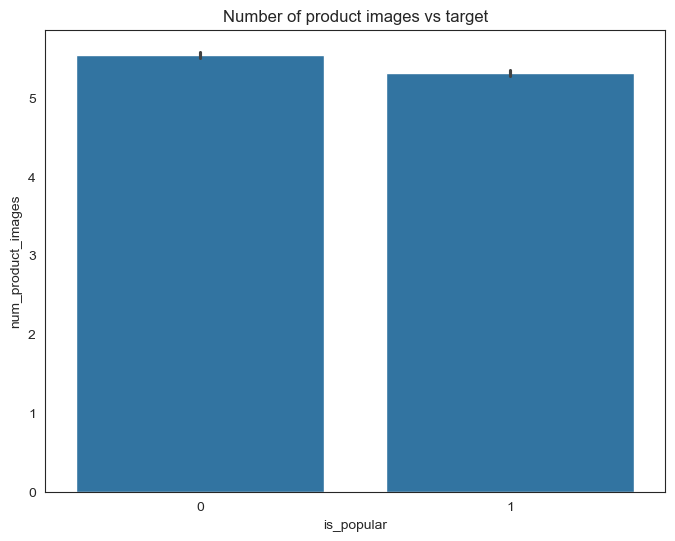

In [64]:
#checking the distribution of number of product images across the target variable
sns.barplot(data=meta_df,x='is_popular',y='num_product_images')
plt.title('Number of product images vs target')
plt.show()

We don't see a strong correlation between the number of product images and popularity of the product.

### <a id='toc1_1_6_'></a>[Dealing with product title, description and feature columns](#toc0_)

All the three columns contain important textual details about the product and could act as an important differentiator about the product's quality and thus their rating. In this section, we will clean these columns and combine the meaningful tokens from each of them to prepare them for vectorization.

In [65]:
#checking first few rows of product title
meta_df['title'].head()

0                    Sterling Silver Hammered Ear Cuff
1    Humorous Cat Wall Art - Decor for Home, Office...
2    Whiskey Glasses by Black Lantern – Floral Whis...
3    LOVE Dog Paw Print Heart Sticker Decal Compati...
4    Bachelorette Party Shirts, Soft Crew Neck and ...
Name: title, dtype: object

In [66]:
#checking first few rows of product description
meta_df['description_product'].head()

0    [This simple ear cuff is made with solid Sterl...
1                               [8x10 UNFRAMED Prints]
2                                                   []
3    [Decal Size: 1" Tall X 3.2" Wide Die cut out o...
4    [Shop now our unique set of bachelorette shirt...
Name: description_product, dtype: object

In [67]:
#checking first few rows of product features
meta_df['features'].head()

0    [Solid Sterling Silver, Artisan Handcrafted, C...
1    [8x10 UNFRAMED PRINTS - NOT Canvas or Tin Sign...
2    [PREMIUM GLASSWARE READY TO GIFT - Our glasses...
3                                                   []
4    [Tear Away Label, Machine Wash, Made in the US...
Name: features, dtype: object

Since Description and Features columns contains lists, we will first need to split all the elements of the list and combine them into a single string to prepare each row for tokenization.

In [68]:
meta_df['description_product'] = meta_df['description_product'].apply(lambda x: ' '.join(x))
meta_df['features'] = meta_df['features'].apply(lambda x: ' '.join(x))

In [69]:
meta_df["product_features"] = meta_df["title"] + " " + meta_df["description_product"] + " "+ meta_df["features"]
meta_df['product_features'].head().values.tolist()

['Sterling Silver Hammered Ear Cuff This simple ear cuff is made with solid Sterling Silver. I have shaped, hammered and polished it carefully by hand. The beautiful hammer marks catch the light beautifully. It fits on the upper ear or the mid ear. It will arrive in nice little jewelry box. Enjoy! These are in stock and ready to ship right away! Solid Sterling Silver Artisan Handcrafted Comes in Gift Box',
 'Humorous Cat Wall Art - Decor for Home, Office or Apartment Decoration - 8x10 Picture Poster Makes Great Gift - Unframed Typography Photo Print 8x10 UNFRAMED Prints 8x10 UNFRAMED PRINTS - NOT Canvas or Tin Sign UNIQUE WALL ART DECOR - Cool original home decorations for office, living room, bedroom, bathroom, family room, man cave, dorm, dining room, kitchen, classroom, apartment, bar, baby nursery PERFECT PRESENT FOR EVERY OCCASION - Cute gift ideas for women, wife, girlfriend, her, girls, daughter, men, guys, boys, son, husband, boyfriend, him, kids, teens, best friend, cat lover,

In [70]:
#Drop description and features columns
meta_df.drop(columns=['features','description_product'], inplace=True)

It could also be useful to tokenize the product categories, as some categories might be related to higher ratings while others may not.  We create a column called `title_category` that combines the title of the product and the category it belongs to which we could tokenize during the modeling.

In [71]:
meta_df["title_category"] = meta_df["title"] + " " + meta_df["combined_category"]
meta_df['title_category'].head().values.tolist()

['Sterling Silver Hammered Ear Cuff Jewelry Earrings Ear Cuff',
 'Humorous Cat Wall Art - Decor for Home, Office or Apartment Decoration - 8x10 Picture Poster Makes Great Gift - Unframed Typography Photo Print Home & Kitchen Artwork Prints',
 'Whiskey Glasses by Black Lantern – Floral Whiskey Glass Set and Bar Glasses – Flower Rock Glass - Kitchen and Drinking Glasses (Set of Two 11oz. Glasses) - Modern Drinkware Home & Kitchen Dining Tableware Glassware Tumblers',
 'LOVE Dog Paw Print Heart Sticker Decal Compatible With iPad MacBook Pro Air 13" 15" 17" Keyboard Keypad Mousepad Trackpad Laptop Sticker Puppy Gift Tablet Computer Decal Electronics Accessories Laptop Skins & Decals',
 'Bachelorette Party Shirts, Soft Crew Neck and V-Neck Customizable T-Shirts For the Bride, Bridesmaid, Maid of Honor, Matron of Honor, Mother of the Bride with Rose Gold Foil Designs Clothing Shoes & Accessories Men Tops Tees T-Shirts']

#### <a id='toc1_1_6_1_'></a>[Tokenizing Product titles and descriptions](#toc0_)

In this section, we implement a Spacy tokenizer to process the `product_features` column. We then apply a TF-IDF vectorizer to identify important tokens for a few stores. During modeling, we will implement proper vectorization within a pipeline to prevent data leakage.  

In [72]:
# Load the large English pipeline
nlp = spacy.load('en_core_web_lg', disable=["parser", "ner"])  # Disabling parser & NER for efficiency

def normalize_text(text):
    """
    Normalizes text by converting special Unicode characters into standard ASCII.
    """
    normalized_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return normalized_text

def custom_tokenizer(row):
    """
    Tokenizes and lemmatizes a product title, normalizing Unicode characters
    and removing stopwords.

    Args:
        row (str): A product title or description.

    Returns:
        str: Processed text with lemmatized words.
    """
    # Normalize Unicode styles
    normalized_text = normalize_text(row)

    # Process text with SpaCy
    parsed_title = nlp(normalized_text)

    # Extract only relevant tokens
    tok_lemmas = [
        token.lemma_.lower()    # Convert lemma to lowercase
        for token in parsed_title 
        if token.is_alpha       # Ensure token is alphabetic
        and not token.is_stop   # Remove stopwords
        and len(token) > 3      # Ignore very short words
        and token.pos_ in ("ADJ", "NOUN", "PROPN")  # Extract nouns and adjectives
    ]

    # Remove duplicates while preserving order
    unique_tokens = list(dict.fromkeys(tok_lemmas))

    return unique_tokens  # Convert list to a single string


In [73]:
#tfidf using custom tokenizer
tfidf_vect = TfidfVectorizer(tokenizer=custom_tokenizer,
                                   lowercase=True,
                                   min_df=10,
                                   max_df=0.30,
                                   max_features=2000,                  
                                   stop_words='english',   
                                   )         

# Fit 
tfidf_vect.fit(meta_df['product_features'])

#Transform - output is a sparse matrix
transformed_features = tfidf_vect.transform(meta_df['product_features'])

#convert to dataframe
tokens_df  = pd.DataFrame(transformed_features.toarray(), columns= tfidf_vect.get_feature_names_out())

print(f'Shape of transformed array of tokenized features from product_features: {tokens_df.shape}')


Shape of transformed array of tokenized features from product_features: (38154, 2000)


In [74]:
#checking a few most common tokens in the dataset
tokens_df.sum(axis=0).sort_values(ascending=False).head(20)

inch         1011.037533
design        858.788333
high          857.095364
silver        844.065440
great         842.031123
hand          823.999420
custom        752.346043
print         744.182059
decor         722.406377
jewelry       719.809343
wall          712.889737
unique        697.073511
free          688.329732
available     665.498170
material      665.464567
home          662.042687
white         656.204490
ready         648.499703
beautiful     643.081383
birthday      635.454714
dtype: float64

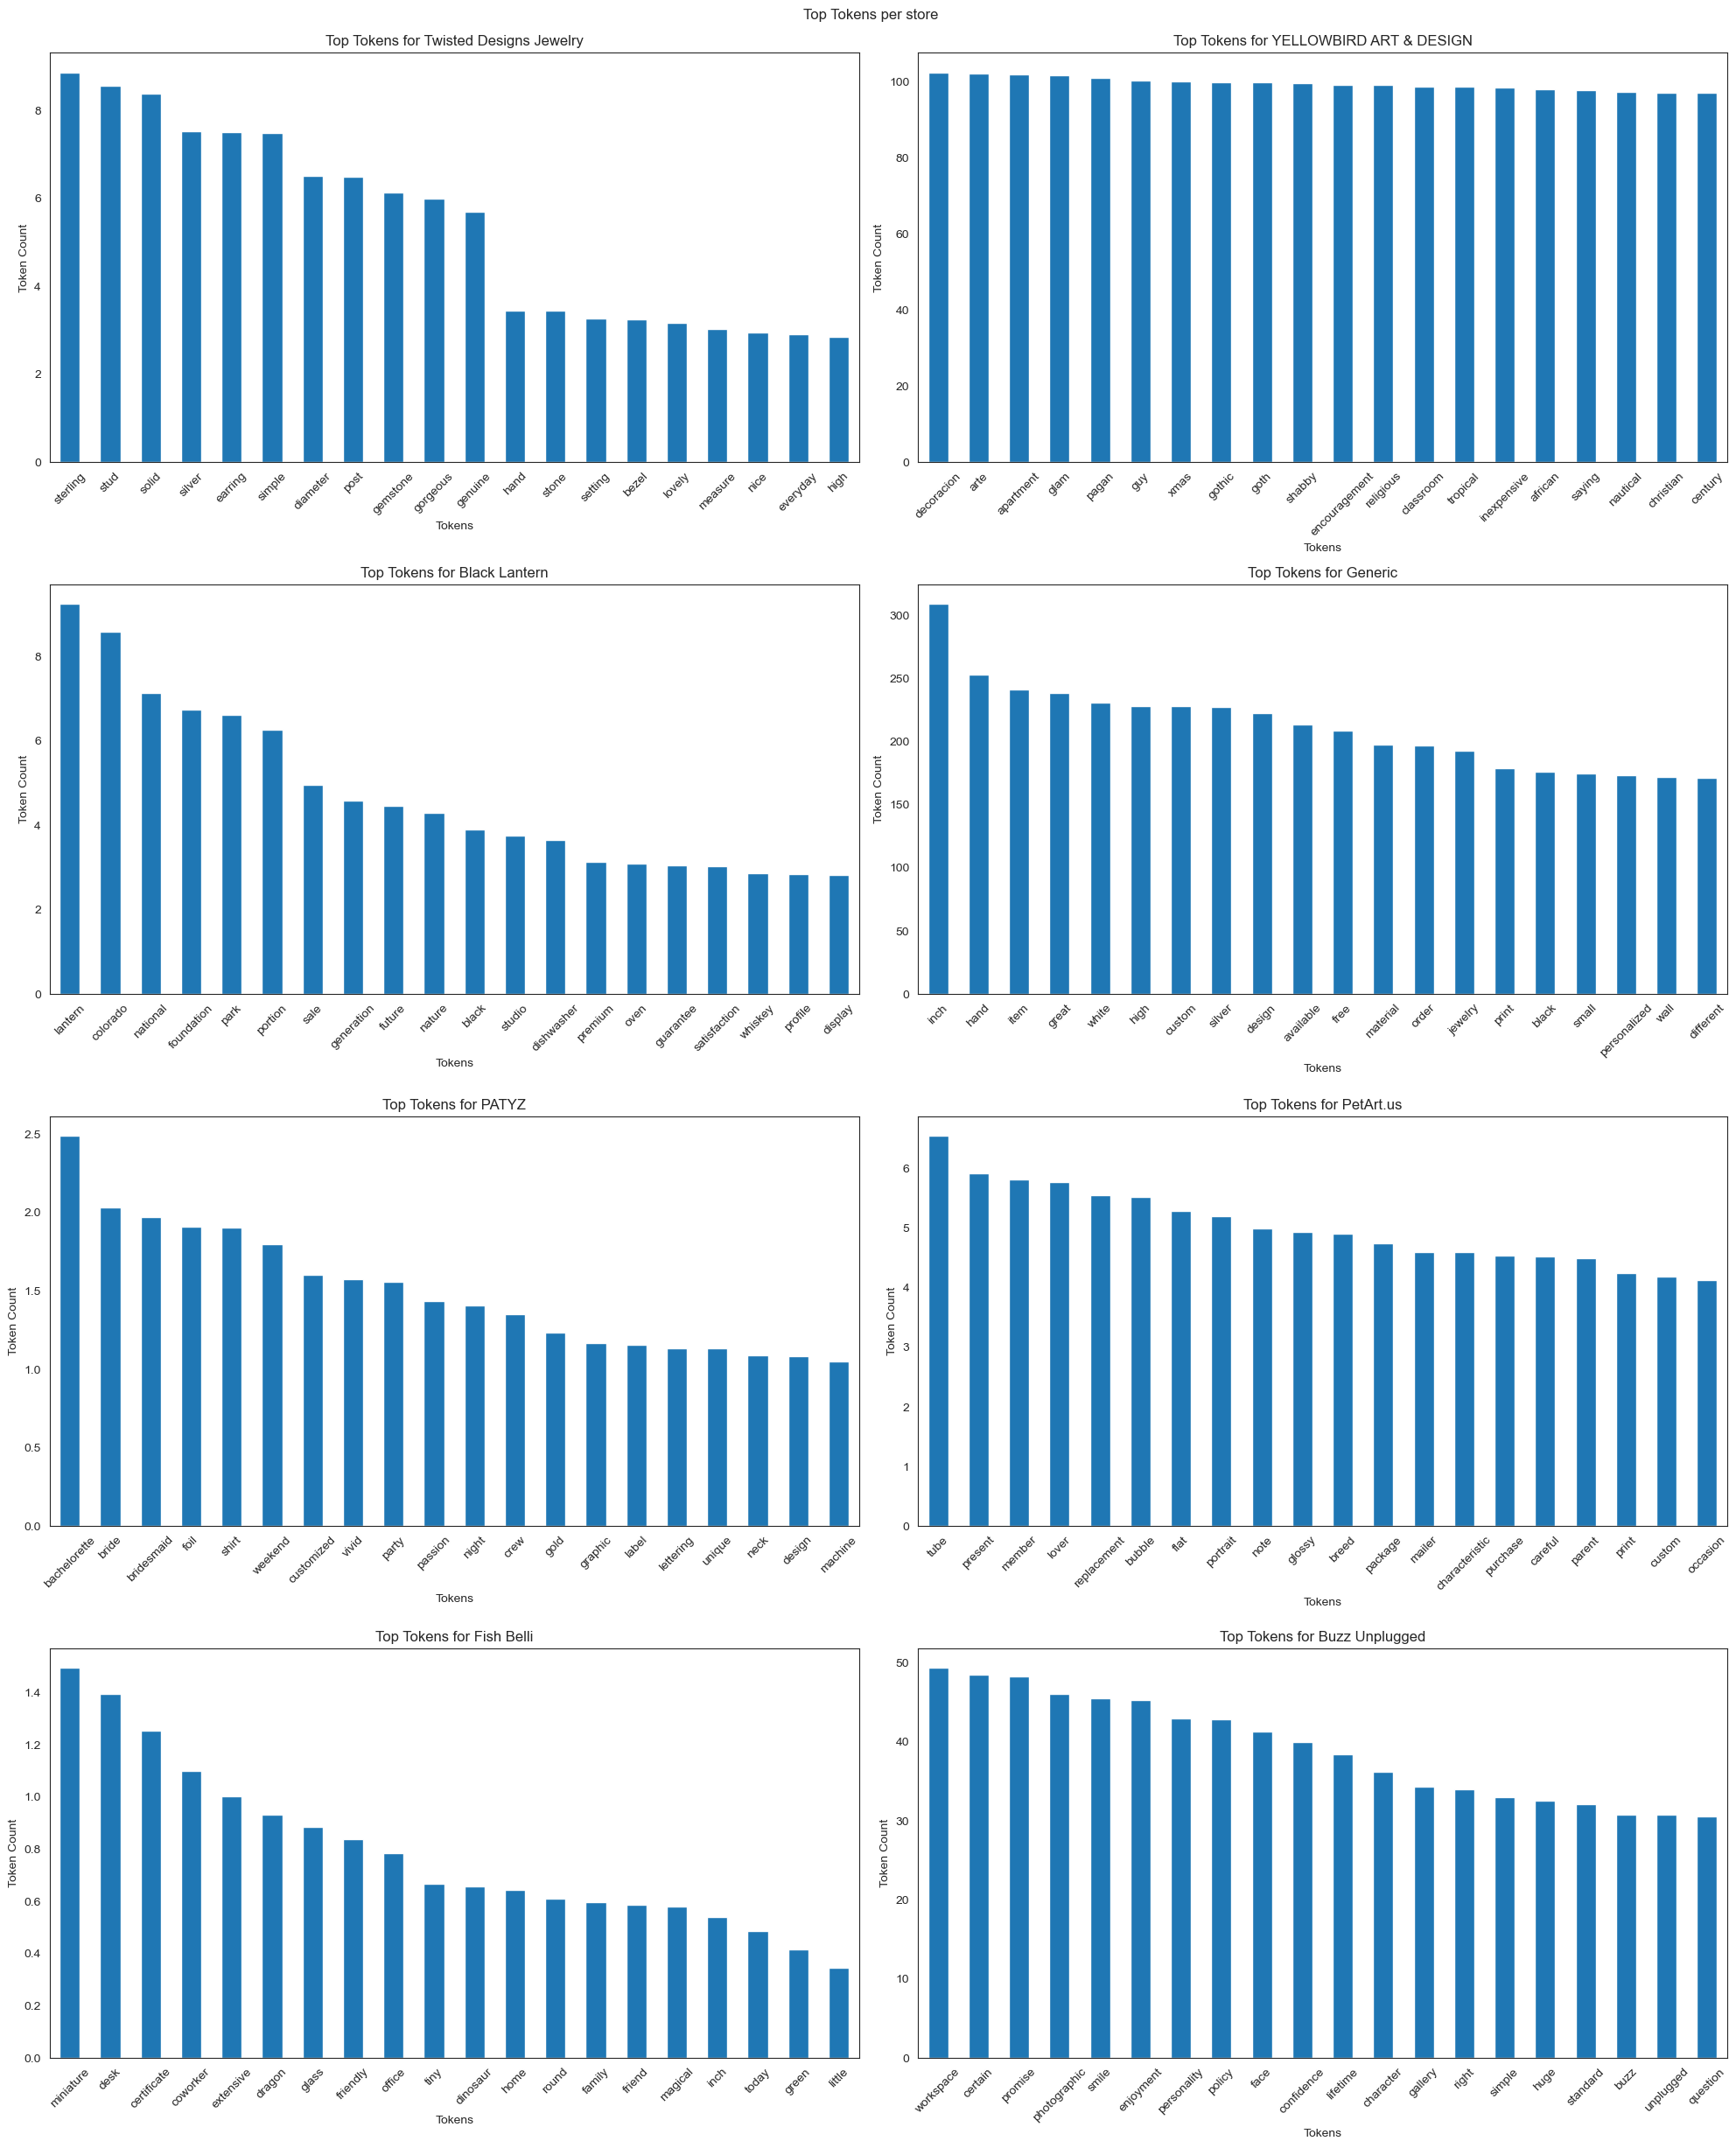

In [75]:
#visualize tokens for  products from similar store

# Extract unique store names
storenames = meta_df['store'].unique().tolist()

plt.figure(figsize=(20, 25))  

# Loop through the first 8 stores
for idx, store in enumerate(storenames[:8]):
    # Create a subplot dynamically
    plt.subplot(4, 2, idx + 1)  # 4 rows, 2 columns, current subplot position (idx + 1)
    
    # Filter rows corresponding to the current store
    rows = meta_df['store'] == store
    
    # Sum token counts for the filtered rows
    tokens_store = tokens_df[rows].sum(axis=0)
    
    # Sort tokens in descending order
    tokens_store = tokens_store.sort_values(ascending=False)
    
    # Plot top 20 tokens
    tokens_store.head(20).plot(kind='bar')

    # plt.legend()
    plt.title(f"Top Tokens for {store}")  
    plt.xticks(rotation=45)
    plt.ylabel("Token Count")
    plt.xlabel("Tokens")

plt.suptitle('Top Tokens per store\n \n')

# Adjust layout to prevent overlap
plt.tight_layout() 


# Show the plot
plt.show()

Some of the most common tokens across all products include handicraft, rated, wholesaler, which align well with expectations. 
Additionally, the top tokens for each store reflect the types of products sold by that store.   

In [76]:
#Lets also tokenize `title_category` and compare the tokens

tfidf_vect = TfidfVectorizer(tokenizer=custom_tokenizer,
                                   lowercase=True,
                                   min_df=10,
                                   max_df=0.90,
                                   max_features=2000,                  
                                   stop_words='english',   
                                   )         

# Fit 
tfidf_vect.fit(meta_df['title_category'])

#Transform - output is a sparse matrix
transformed_features = tfidf_vect.transform(meta_df['title_category'])

#convert to dataframe
tokens_df  = pd.DataFrame(transformed_features.toarray(), columns= tfidf_vect.get_feature_names_out())

print(f'Shape of transformed array of tokenized features from title_category: {tokens_df.shape}')

Shape of transformed array of tokenized features from title_category: (38154, 2000)


In [77]:
#checking a few most common tokens in the dataset
tokens_df.sum(axis=0).sort_values(ascending=False).head(20)

kitchen       1890.305901
home          1865.580285
jewelry       1690.278926
decor         1515.878902
gift          1376.765800
accessory     1317.971417
artwork       1244.091780
print         1129.191652
wall          1031.827392
silver         944.066390
necklace       912.374603
pendant        793.162333
woman          783.613980
decorative     760.347555
party          759.560773
shoe           736.579654
clothing       735.279007
earring        727.281881
handmade       712.747441
stationery     680.535959
dtype: float64

#### <a id='toc1_1_6_2_'></a>[Product title length](#toc0_)

In this section, we will explore the relationship between the length of product titles with our target variable. Essentially, we would like to see if longer titles  results in better ratings or not.

In [78]:
#storing length of product title/desc in a separate column
meta_df['product_title_length'] = meta_df['title'].apply(len).fillna(0)

meta_df['product_title_length'].describe()


count    38154.000000
mean       112.709572
std         48.727242
min          0.000000
25%         74.000000
50%        109.000000
75%        150.000000
max        236.000000
Name: product_title_length, dtype: float64

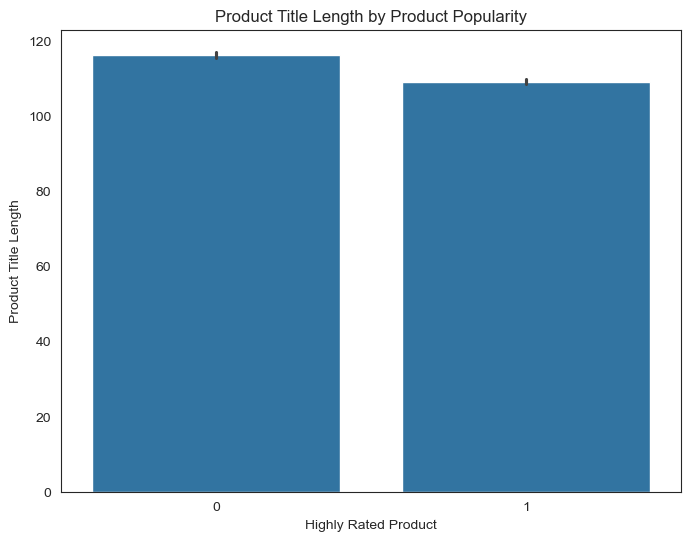

In [79]:
#Check distribution of product title lengths across target variable

# Create the bar plot
sns.barplot(data=meta_df, x='is_popular', y='product_title_length')

# Add labels and title
plt.xlabel('Highly Rated Product')
plt.ylabel('Product Title Length')
plt.title('Product Title Length by Product Popularity')
plt.show()

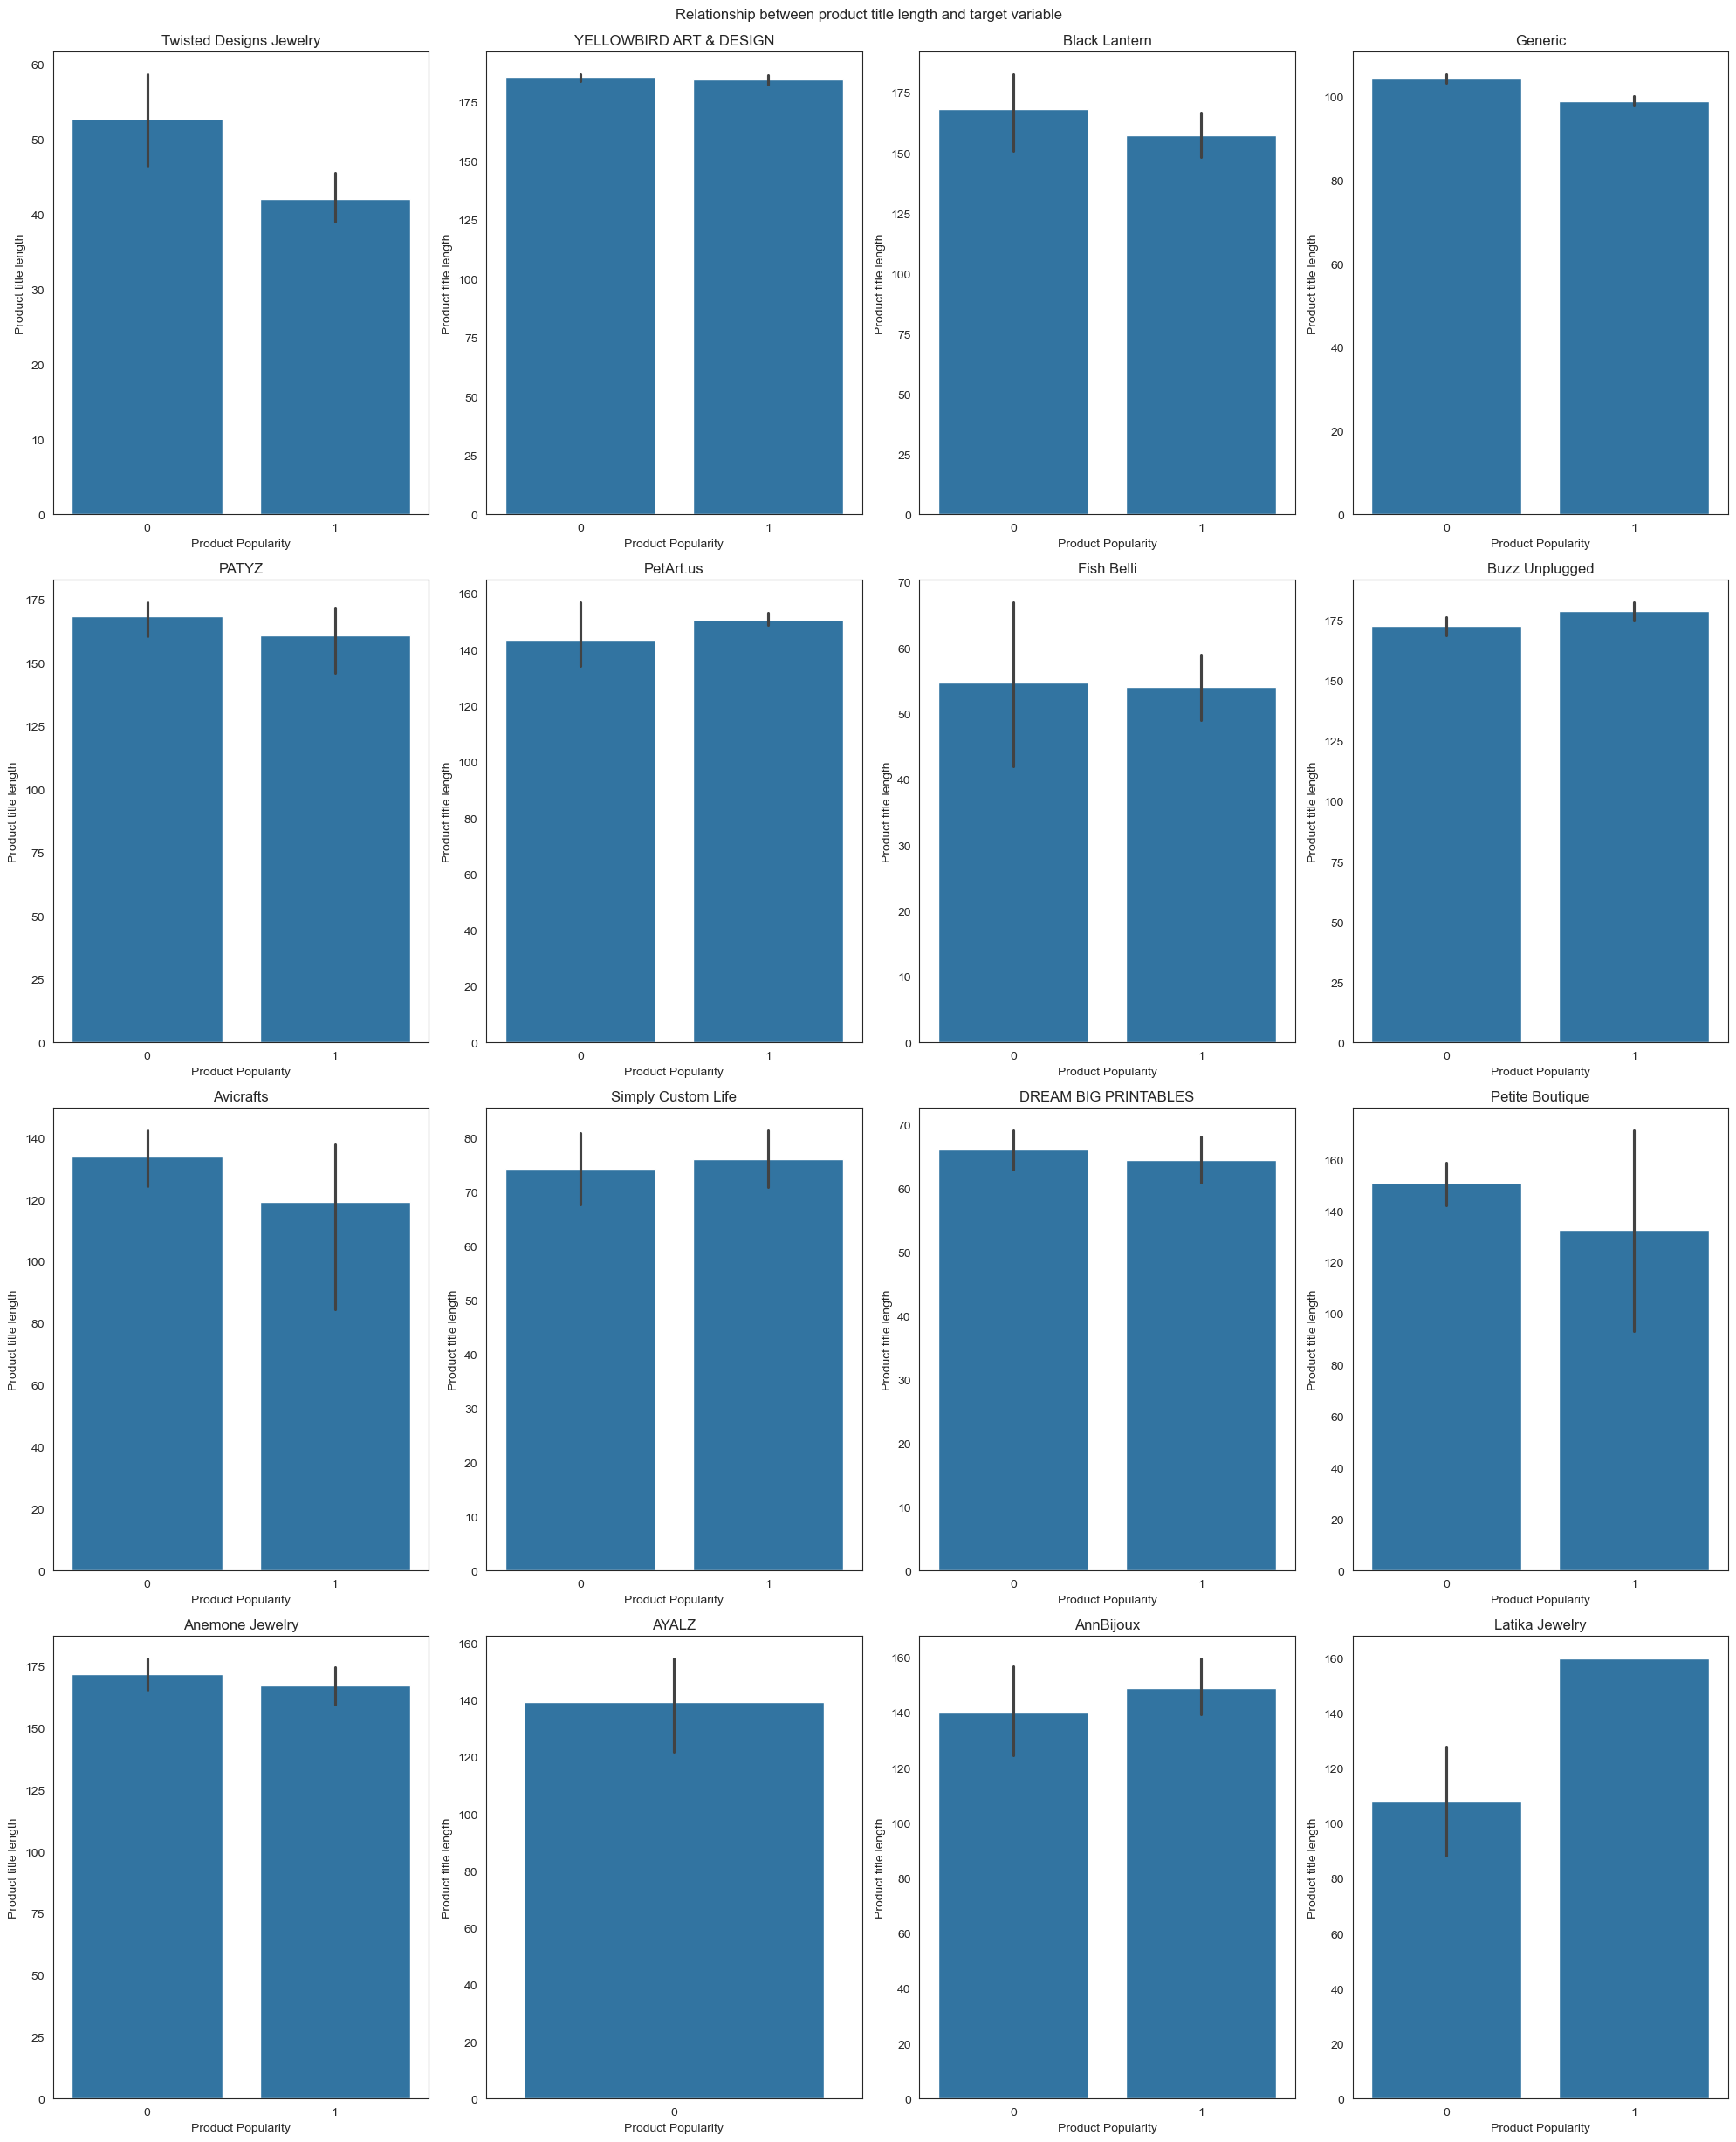

In [80]:
#For a given store- do we see any correlation between the length of the title and average rating of the product?

# Extract unique store names
storenames = meta_df['store'].unique().tolist()

plt.figure(figsize=(20, 25))  

# Loop through the first 8 stores
for idx, store in enumerate(storenames[:16]):
    # Create a subplot dynamically
    plt.subplot(4, 4, idx + 1)  # 4 rows, 2 columns, current subplot position (idx + 1)
    
    # Filter rows corresponding to the current store
    rows = meta_df['store'] == store

    sns.barplot(data = meta_df[rows],y = 'product_title_length',x ='is_popular' )

    plt.title(f"{store}")  
    plt.ylabel("Product title length")
    plt.xlabel("Product Popularity")

plt.suptitle('Relationship between product title length and target variable\n \n')

# Adjust layout to prevent overlap
plt.tight_layout() 


# Show the plot
plt.show()


**Key Insights**
- For overall dataset, we see that the mean title length of low rated products is slightly higher than high rated products.

- At a store level, we also see that some stores have high rated items with longer titles, while for some other stores, title length doesn't have a relationship with the rating of an item. 

### <a id='toc1_1_7_'></a>[Dealing with store column](#toc0_)

In [81]:
#inspect values in store column
meta_df['store'].unique()[:10]

array(['Twisted Designs Jewelry', 'YELLOWBIRD ART & DESIGN',
       'Black Lantern', 'Generic', 'PATYZ', 'PetArt.us', 'Fish Belli',
       'Buzz Unplugged', 'Avicrafts', 'Simply Custom Life'], dtype=object)

Some store names are in capital letters, therefore lets check the number of unique store names after changing to lower case.

In [82]:
print(f"There are {meta_df['store'].nunique()- meta_df['store'].str.lower().nunique()} duplicate labels for stores.")

There are 25 duplicate labels for stores.


In [83]:
#combine duplicate labels
meta_df['store'] = meta_df['store'].str.lower()

print(f"There are {meta_df['store'].nunique()} unique stores/sellers in the dataset.")


There are 3455 unique stores/sellers in the dataset.


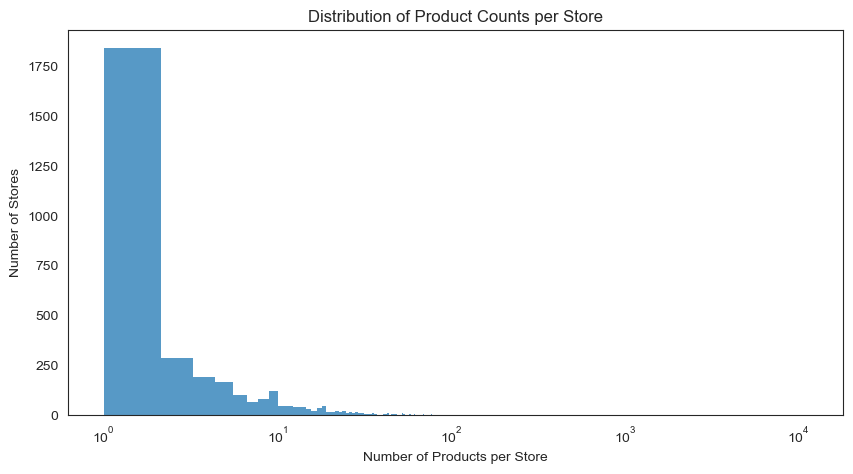

In [84]:
#Checking the size of stores in the dataset
store_counts = meta_df["store"].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(store_counts,bins=10000)
plt.xscale('log')
plt.xlabel("Number of Products per Store")
plt.ylabel("Number of Stores")
plt.title("Distribution of Product Counts per Store")
plt.show()

In [85]:
store_counts.describe()

count     3455.000000
mean        11.043126
std        193.919148
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max      11323.000000
Name: count, dtype: float64

In [86]:
num = store_counts[store_counts == 1].sum()/len(store_counts)*100
print(f'There are {np.round(num)}% of stores with only 1 product.')

There are 40.0% of stores with only 1 product.


**Key Insights**
- The distribution of product counts within a store is highly skewed towards lower values.
- Most of the stores in the dataset have 2 or fewer products. 
- Looks like the "generic store" iappears to be a placeholder rather than an actual store name, likely representing multiple stores with missing names.

Since generic store accounts for 30% of the products, we create a special flag to help the model distinguish from other stores.

In [87]:
#Since generic store name is a placeholder for no store name, we mark it for special handling
meta_df['is_generic_store'] = np.where(meta_df['store'] == 'generic',1,0)
meta_df['is_generic_store'].value_counts()

is_generic_store
0    26831
1    11323
Name: count, dtype: int64

Lets also look at the distribution of ratings within these stores.

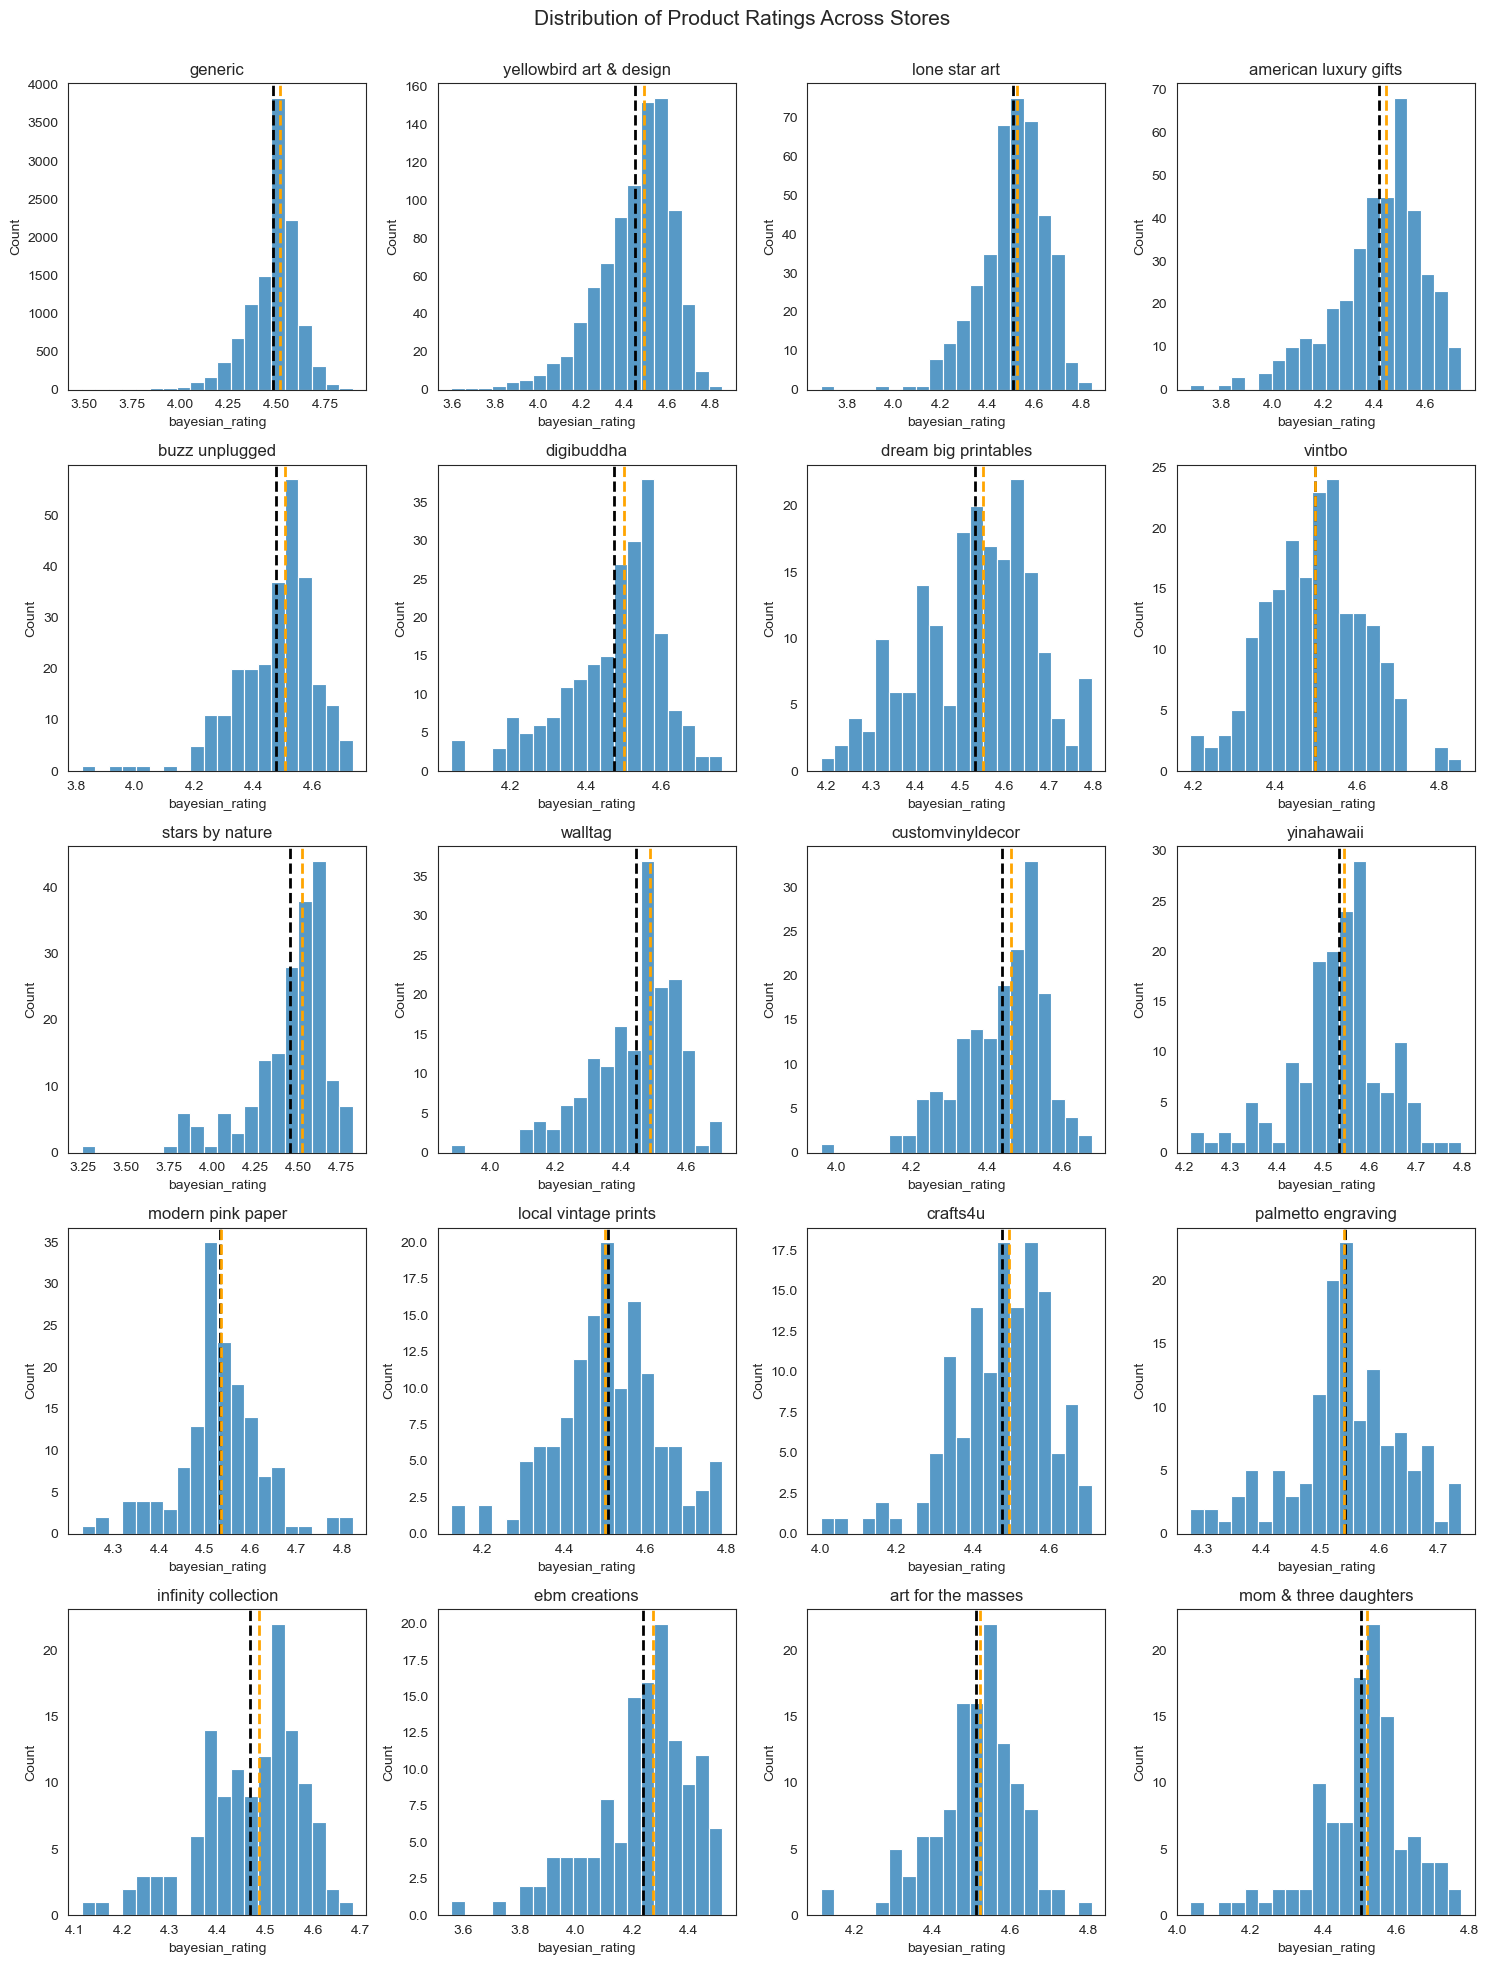

In [88]:
#we only filter stores with more than 100 items - for visualization purposes only
relevant_stores = meta_df['store'].value_counts().loc[lambda x: x>100].index.tolist()

plt.subplots(5,4, figsize=(15,20)) # creating subplots structure with 4 rows and 3 columns 

for idx, store in enumerate(relevant_stores): 
 
    plt.subplot(5, 4, idx+1)

    # plot
    sns.histplot(meta_df[meta_df['store'] == store]['bayesian_rating'], bins=20, edgecolor='white')
    plt.axvline(meta_df[meta_df['store'] == store]['bayesian_rating'].mean(), 
                label="Mean", color='black', ls='--', lw=2) # mean vertical line
    plt.axvline(meta_df[meta_df['store'] == store]['bayesian_rating'].median(), 
                label="Median", color='orange', ls='--', lw=2) # median vertical line

    # add title + label
    plt.ylabel("Count")
    plt.title(f'{store}')

plt.suptitle("Distribution of Product Ratings Across Stores \n\n", fontsize=15)
plt.tight_layout()

plt.show()

 **Key Insights** 

 - The distribution of average ratings of products varies across stores.
 
 - Stores like ‘American Luxury Gifts’ and ‘Yellowbird Art Design’ exhibit a right-skewed distribution, suggesting a higher number of popular products compared to unpopular ones. 

- Stores like ‘Vintbo’ and ‘Modern Pink Paper’ exhibit a more normal-like distribution with a more balanced number of popular and unpopular products. 

 - The difference between the mean and median of store ratings is minimal, indicating the absence of outliers. This is due to the use of Bayesian ratings instead of raw averages for prdocut ratings.


Lets now look at the distribution of the target variable for these stores.


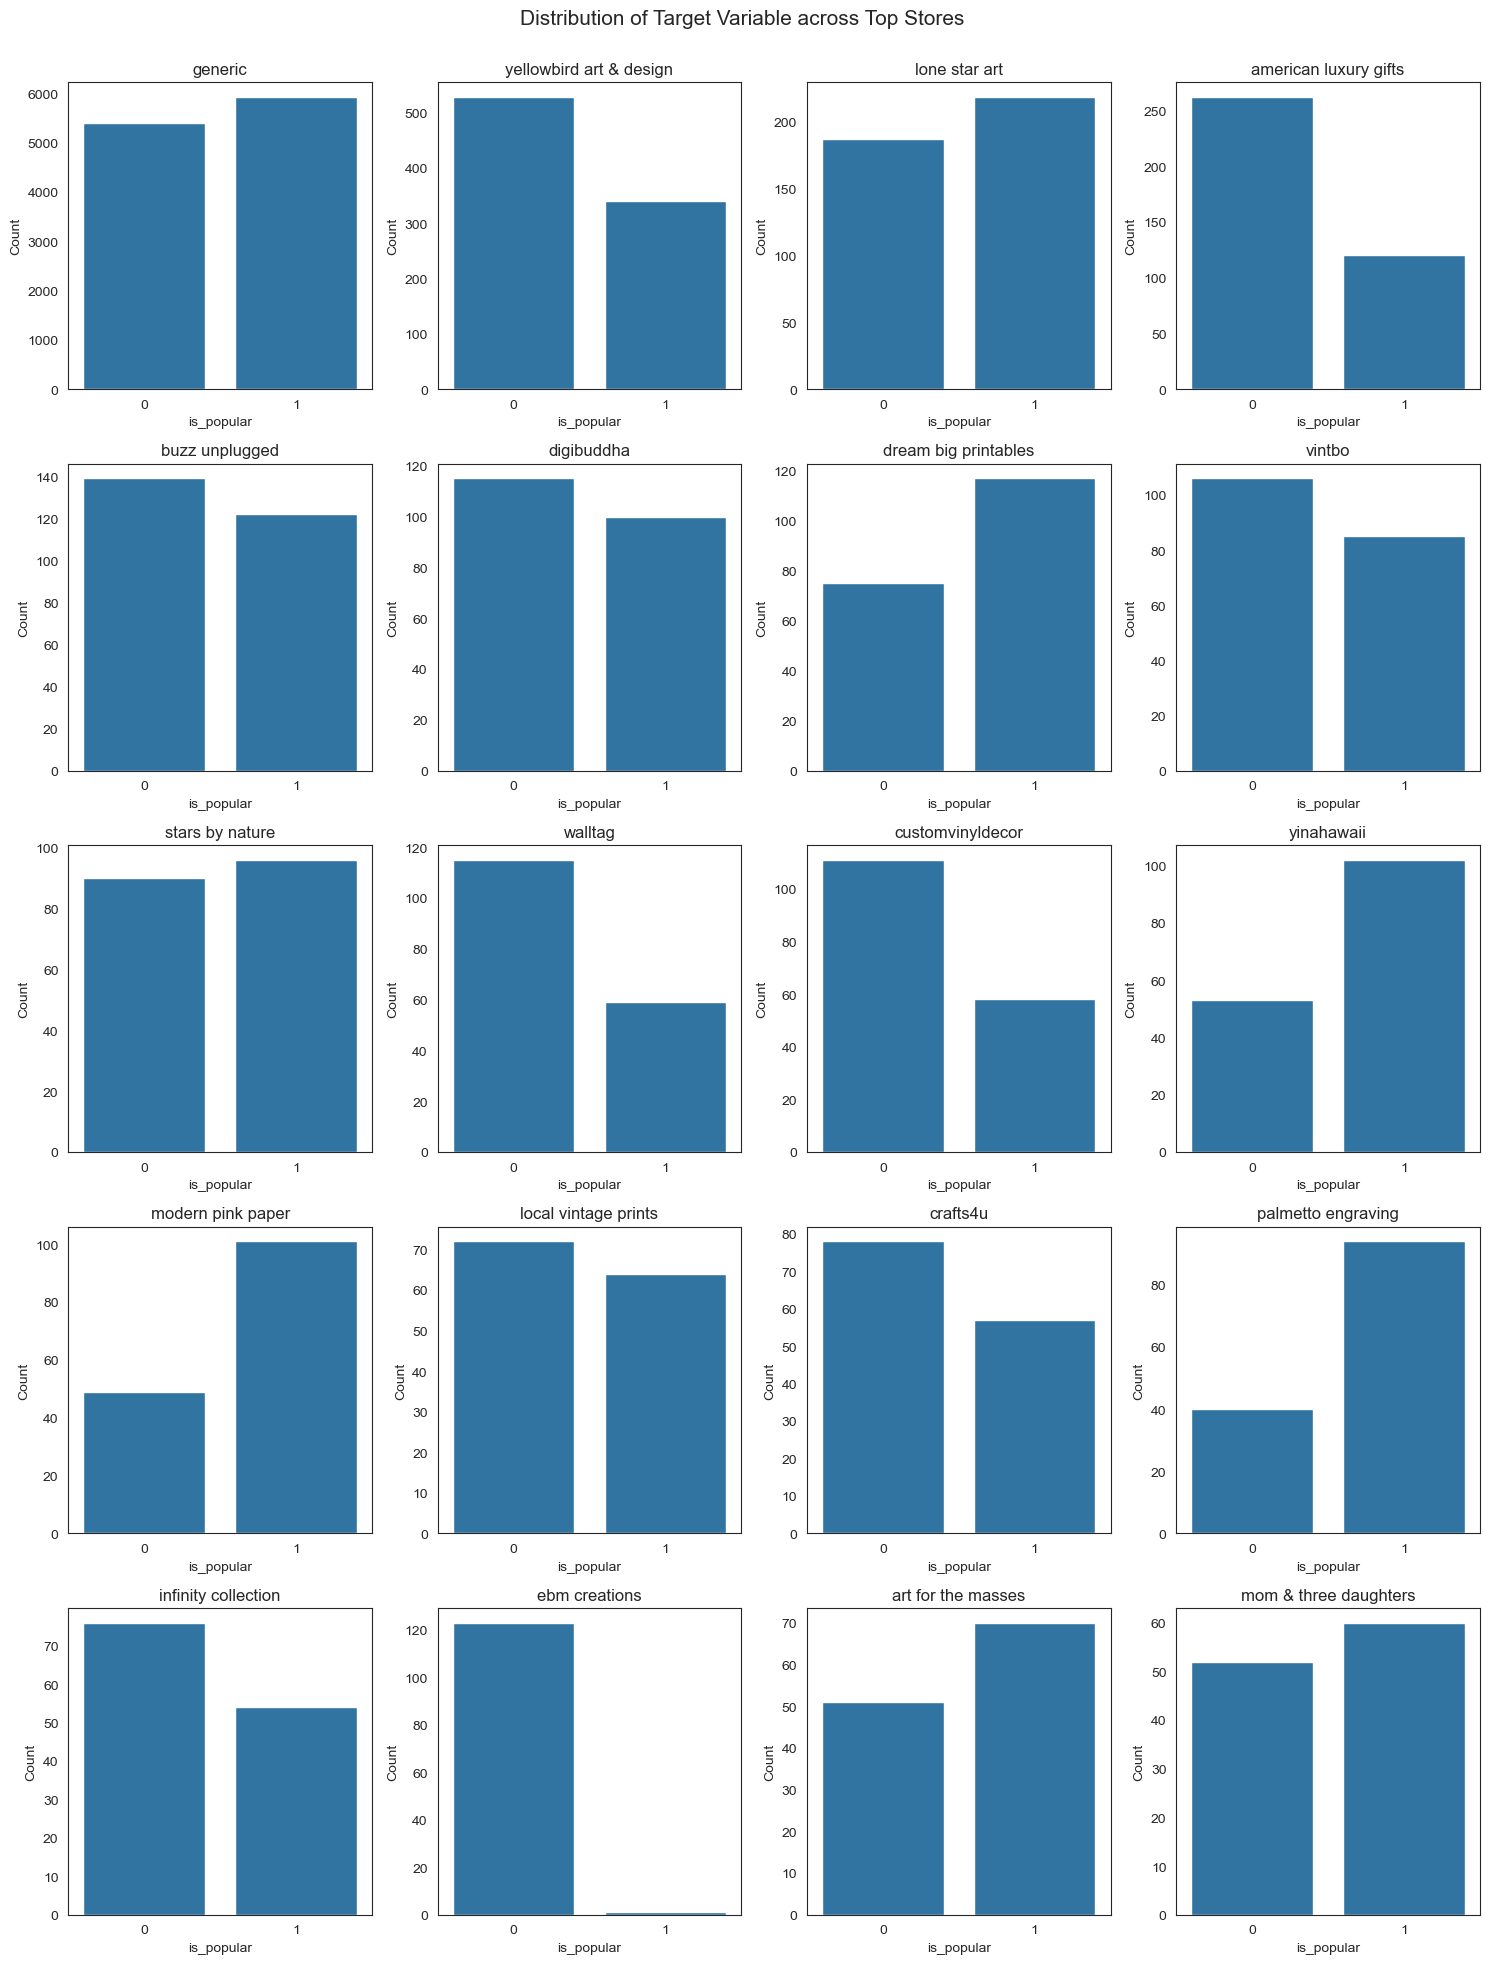

In [89]:
#plot distribution of target variable across different stores 
plt.subplots(5,4, figsize=(15,20)) # creating subplots structure with 4 rows and 3 columns 

for idx, store in enumerate(relevant_stores): 

    #specify destination of plot 
    plt.subplot(5, 4, idx+1) # adding +1 because subplot positions start from 1

    # plot
    sns.countplot(meta_df[meta_df['store'] == store], x = 'is_popular')
    
    # add title + label
    plt.ylabel("Count")
    plt.title(f'{store}')

plt.suptitle("Distribution of Target Variable across Top Stores \n\n", fontsize=15)
plt.tight_layout()

plt.show()

Here we can more clearly see the differences across different stores.

Stores like Infinity Collection, Walltag and Crafts4U have a higher number of low-rated products than high-rated products. In contrast, stores such as yinahawaii and Palmetto engraving have a significantly larger number of  high-rated products.

Therefore Store could be a useful predictor for our model.   

Next we will explore the following new features based on store-level attributes:  
- Number of unique products sold by each store.  
- Average rating of products sold by a given store.
- Standard Deviation of rating of products sold by a given store.
- Store stability
- Store size 
- Target Encoding per store i.e. popularity score per store

In [90]:
#Construct new features - store based total products and average rating

store_counts = meta_df['store'].value_counts()

## Map the number of products to the store column
meta_df['store_product_counts'] = meta_df['store'].map(store_counts)

# Because total products are heavily skewed, apply log transformation
meta_df['log_store_product_counts'] = np.log1p(meta_df['store_product_counts'])

#create a mean rating per store
store_mean_rating = meta_df.groupby('store')['bayesian_rating'].mean()
meta_df['store_rating_mean'] = meta_df['store'].map(store_mean_rating)

#create a std rating per store
store_std_rating = meta_df.groupby('store')['bayesian_rating'].std()
meta_df['store_rating_std'] = meta_df['store'].map(store_std_rating).fillna(0)

# Coefficient of Variation (lower = more consistent ratings)
meta_df['store_rating_cv'] = meta_df['store_rating_std']/ meta_df['store_rating_mean']  #0.01 added to avoid zeros in denominator


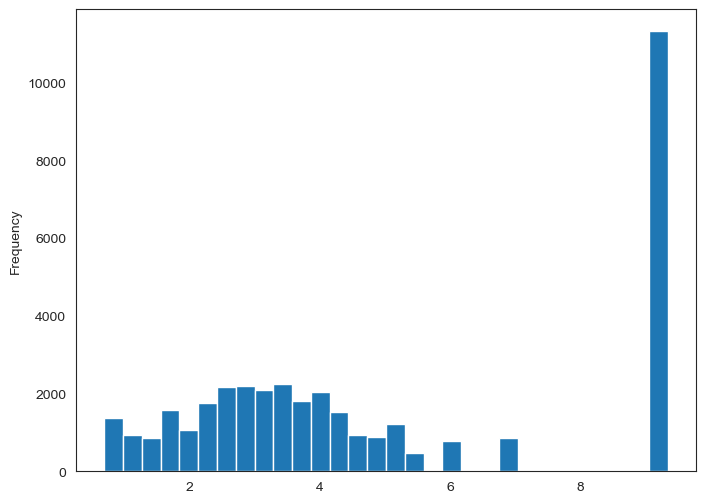

In [91]:
#Checking the distribution of log_store_product_counts
meta_df['log_store_product_counts'].plot(kind='hist',bins=30)
plt.show()

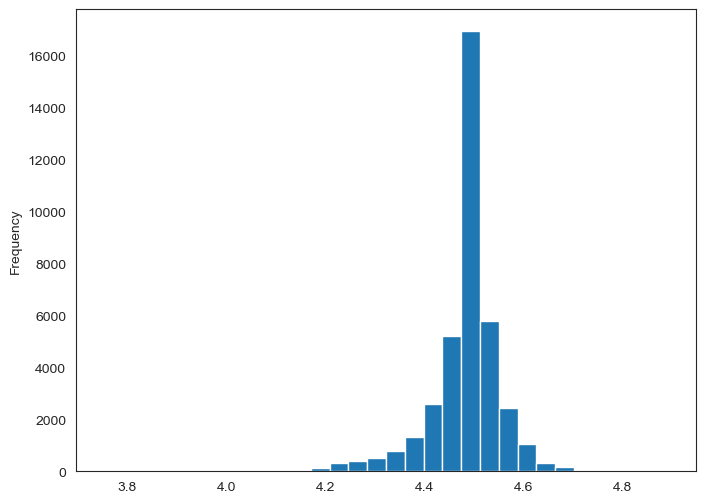

In [92]:
#Checking the distribution of store_rating_mean
meta_df['store_rating_mean'].plot(kind='hist',bins=30)
plt.show()

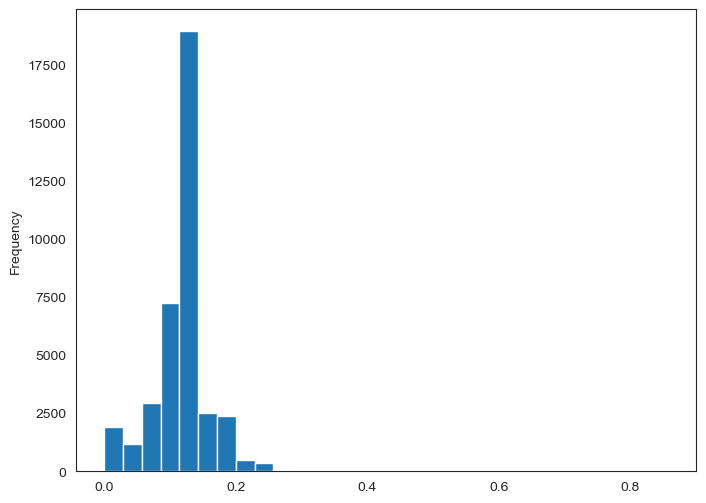

In [93]:
#Checking the distribution of store_rating_std
meta_df['store_rating_std'].plot(kind='hist',bins=30)
plt.show()

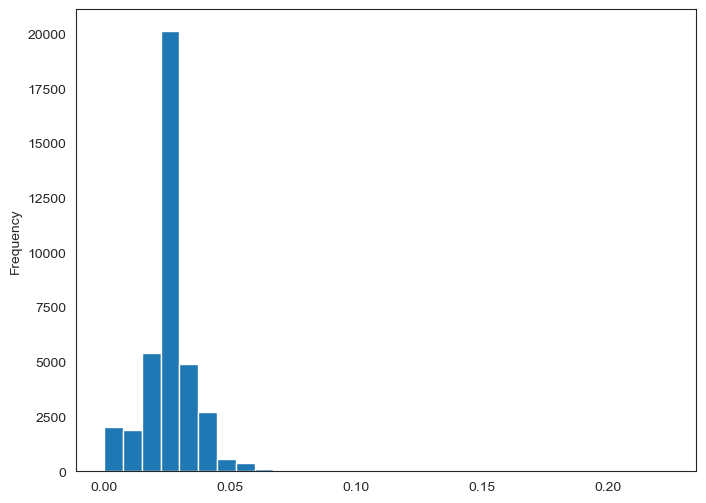

In [94]:
#checking the distribution of store_rating_stability
meta_df['store_rating_cv'].plot(kind='hist',bins=30)
plt.show()

In [95]:
#create new categorical column that represents overall store size
meta_df['store_size_tier'] = np.where(
    meta_df['is_generic_store'] == 0,
    pd.cut(
        meta_df['store_product_counts'],
        bins=[0, 5, 20, 100, np.inf],
        labels=['nano', 'small', 'medium', 'large'],
        right=False
    ),
    'generic' 
)
#checking value counts
meta_df['store_size_tier'].value_counts(dropna=False)

store_size_tier
generic    11323
medium     10653
small       8011
large       4240
nano        3927
Name: count, dtype: int64

As we saw previously, store level averages of the target variable vary significantly. Therefore we create a new feature `store popularity` that represents the historical popularity of products within each store.

In [96]:
#Target encoding per store

store_target_encode = meta_df.groupby('store')["is_popular"].mean()

meta_df["store_target_encoded"] = meta_df['store'].map(store_target_encode)

meta_df["store_target_encoded"].describe()

count    38154.000000
mean         0.505556
std          0.217673
min          0.000000
25%          0.400000
50%          0.523271
75%          0.600000
max          1.000000
Name: store_target_encoded, dtype: float64

### <a id='toc1_1_8_'></a>[Product Age](#toc0_)

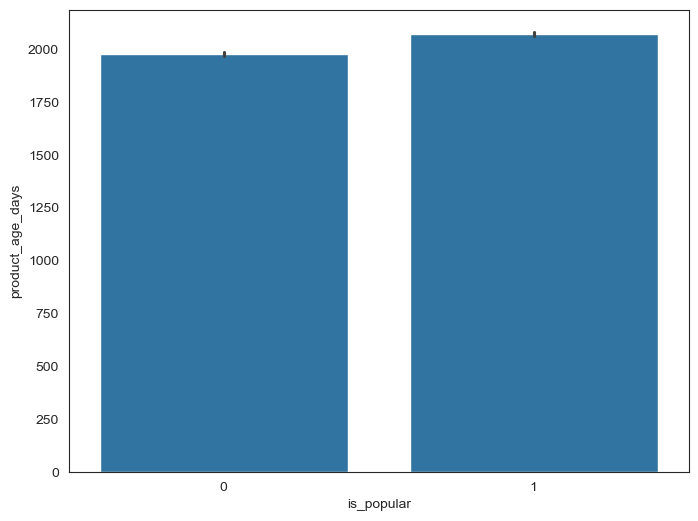

In [97]:
# Calculate the age of the product in days assuming the dataset covers 2023
meta_df['product_age_days'] = (pd.to_datetime('2023-12-31') - meta_df['date_first_available']).dt.days

sns.barplot(x='is_popular',y='product_age_days',data=meta_df)

plt.show()

Older products seem to be associated with slightly higher ratings, however the difference is minimal.

In [98]:
#Create another feature that checks if the product was released over the weekend
meta_df['is_weekend_release'] = meta_df['date_first_available'].dt.dayofweek // 5

### <a id='toc1_1_9_'></a>[Price column](#toc0_)

In [99]:
#check statistical summary of price column
meta_df['price'].describe()

count    38154.000000
mean        30.802116
std         56.879323
min          0.010000
25%         12.990000
50%         19.950000
75%         30.000000
max       3995.000000
Name: price, dtype: float64

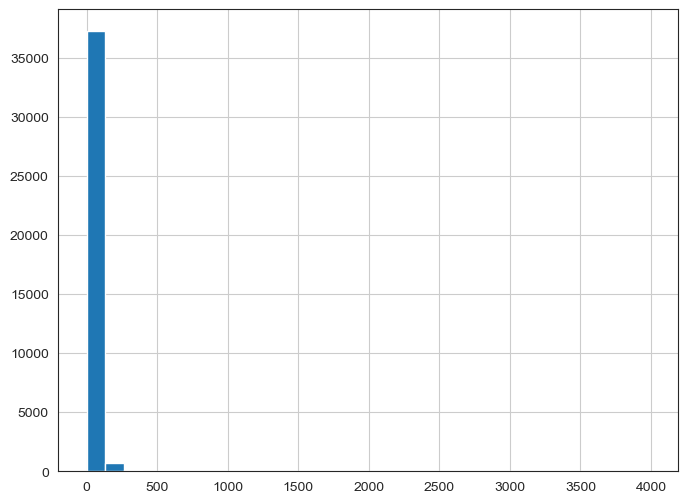

In [100]:
#plot distribution
meta_df['price'].hist(bins=30)
plt.show()

Given the heavy skewness in the price column, we apply the logarithm of the price column and use that as a feature in the model.

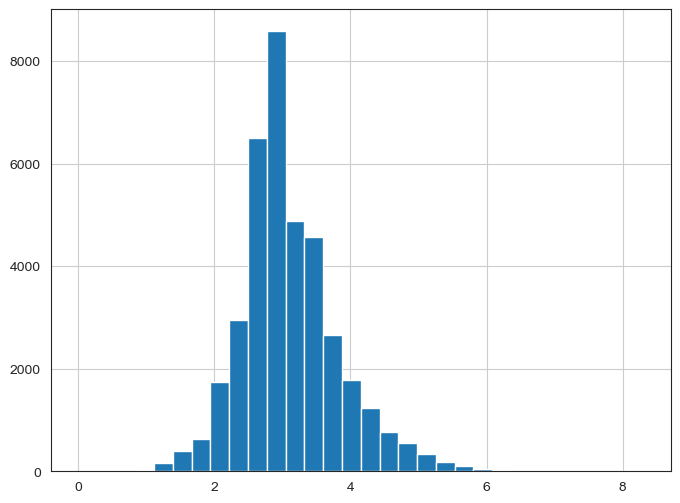

In [101]:
meta_df['log_price'] = np.log1p(meta_df['price'])
meta_df['log_price'].hist(bins=30)  #plot
plt.show()

### <a id='toc1_1_10_'></a>[ Sub_categories and Department columns](#toc0_)

In [102]:
meta_df[['sub_category_1','sub_category_2','sub_category_3','sub_category_4']].isna().sum()

sub_category_1        0
sub_category_2        0
sub_category_3     1861
sub_category_4    28395
dtype: int64

Since we only have the top 2 hierarchical categories for all the products, it makes sense to create a combined_category column that merges sub-category 1 and sub-category 2. We can then use this combined_category column to generate category-level statistics of product ratings.

In [103]:
#renaming the original combined_category that contains information about all 4 subcategories

meta_df.rename(columns={"combined_category":"all_subcategories"},inplace=True)

In [104]:
meta_df['sub_category_1'].value_counts()

sub_category_1
Home & Kitchen                   16302
Jewelry                          11593
Clothing, Shoes & Accessories     3870
Stationery & Party Supplies       3161
Beauty & Grooming                 1001
Sports & Outdoors                  657
Electronics Accessories            461
Pet Supplies                       361
Toys & Games                       301
Baby                               249
Health & Personal Care             198
Name: count, dtype: int64

In [105]:
# This function combines sub_category_1 label and sub_category_2 label into a single 'combined_category' field. 

def combine_categories(row, category_counts, min_threshold=10):
    """
    Combines sub_category_1 and sub_category_2.
    

    Args:
    row (pd.Series): A row of the DataFrame.
    category_counts (dict): A dictionary mapping combined categories to their counts.
    min_threshold (int): Minimum number of rows a category should have.

    Returns:
    str: Concatenated string of sub_category_1 and adjusted sub_category_2.
    """
    no_duplicate_combined = []
    
    sub_category_1 = row['sub_category_1']
    sub_category_2 = row['sub_category_2']
    
    combined = f"{sub_category_1} {sub_category_2}"
    
    # Remove duplicate words
    for x in re.split(r"[, ]+", combined): 
        if x not in no_duplicate_combined:
            no_duplicate_combined.append(x)
    
    combined_category = ' '.join(no_duplicate_combined)
    return combined_category


In [106]:
#temporarily store combine category
meta_df['combined_category_temp'] = meta_df['sub_category_1'] + ' ' + meta_df['sub_category_2']
#compute category counts
category_counts = meta_df['combined_category_temp'].value_counts().to_dict()
# Apply function to create final combined category
meta_df['combined_category'] = meta_df.apply(lambda row: combine_categories(row, category_counts), axis=1)

# Drop the temporary column
meta_df.drop(columns=['combined_category_temp'], inplace=True)

meta_df['combined_category'].value_counts()

combined_category
Home & Kitchen Artwork                        7350
Home & Kitchen Décor                          6006
Jewelry Necklaces                             3775
Stationery & Party Supplies                   3161
Jewelry Earrings                              2899
                                              ... 
Sports & Outdoors Cycling                        6
Toys & Games Puppets                             5
Toys & Games Musical Toy Instruments             4
Baby Carriers                                    4
Health & Personal Care Wellness Relaxation       2
Name: count, Length: 69, dtype: int64

Lets look at the distribution of popular products for sub-category-1 and sub-category-2.

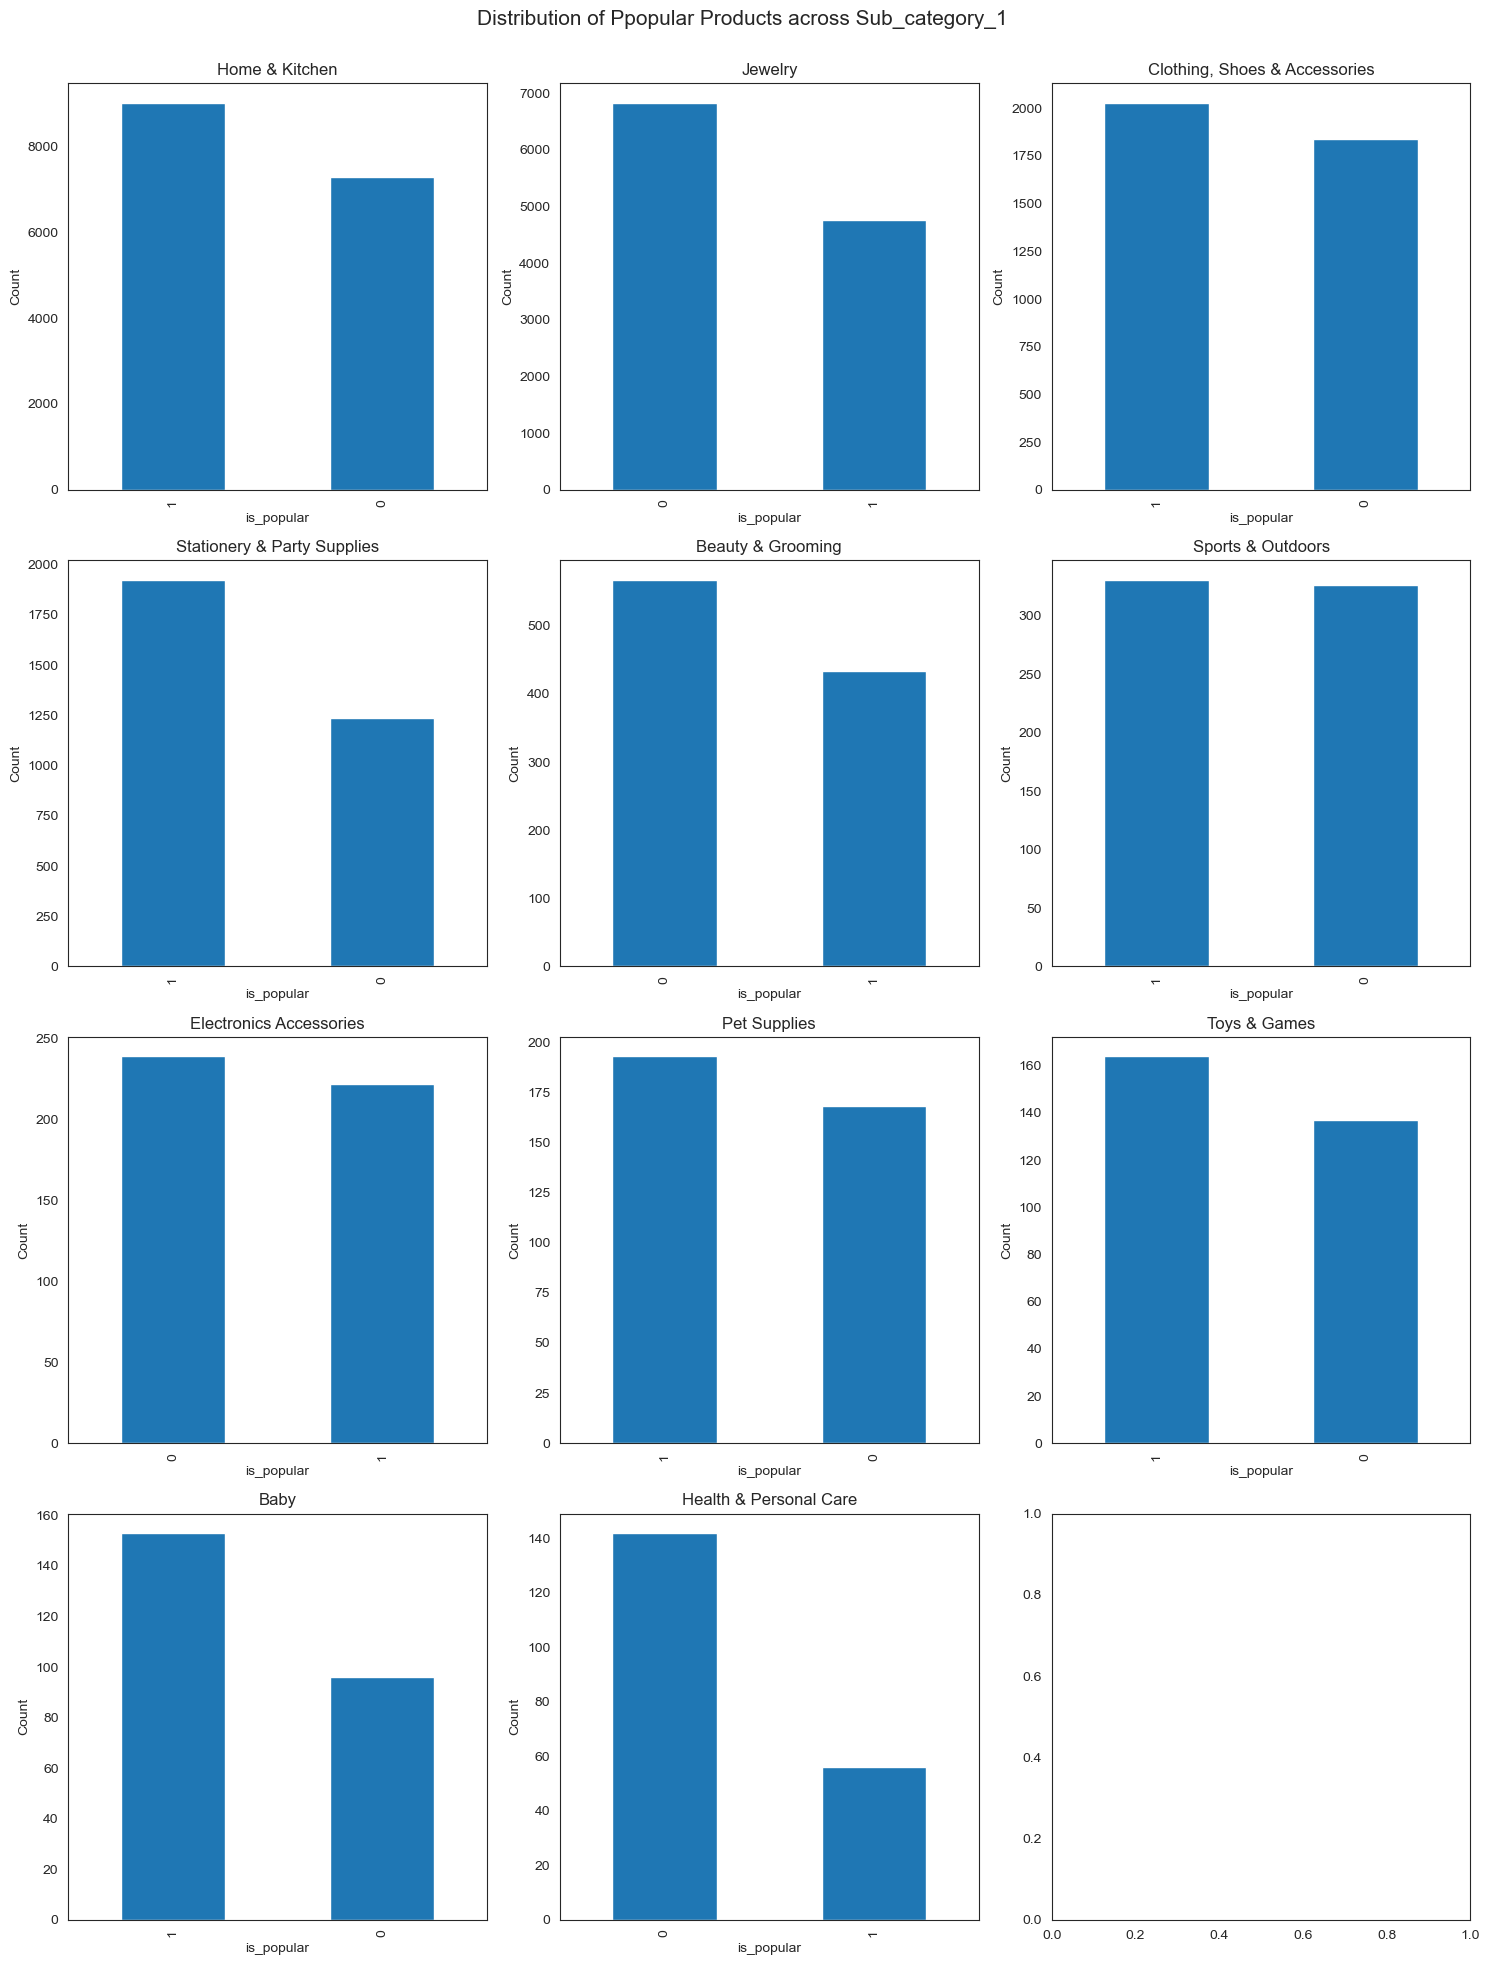

In [107]:
relevant_subcat = meta_df['sub_category_1'].value_counts().index.tolist()

plt.subplots(4,3, figsize=(15,20)) # creating subplots structure with 4 rows and 3 columns 

for idx, subcat in enumerate(relevant_subcat): 

    plt.subplot(4, 3, idx+1) # adding +1 because subplot positions start from 1

    # plot
    meta_df[meta_df['sub_category_1'] == subcat]['is_popular'].value_counts().plot(kind='bar')
    
    # add title + label
    plt.ylabel("Count")
    plt.title(f'{subcat}')

plt.suptitle("Distribution of Ppopular Products across Sub_category_1 \n\n", fontsize=15)
plt.tight_layout()

plt.show()

Some categories have higher number of popular products than others. Therefore using sub-catgory-1 could help differentiate product's average rating. Lets also look at the distribution of target variable across sub-category-2.

In [108]:
#Subsetting only a few categories for visualization
relevant_subcat = meta_df['combined_category'].value_counts().loc[lambda x: (x>30) & (x<50)].index.tolist()

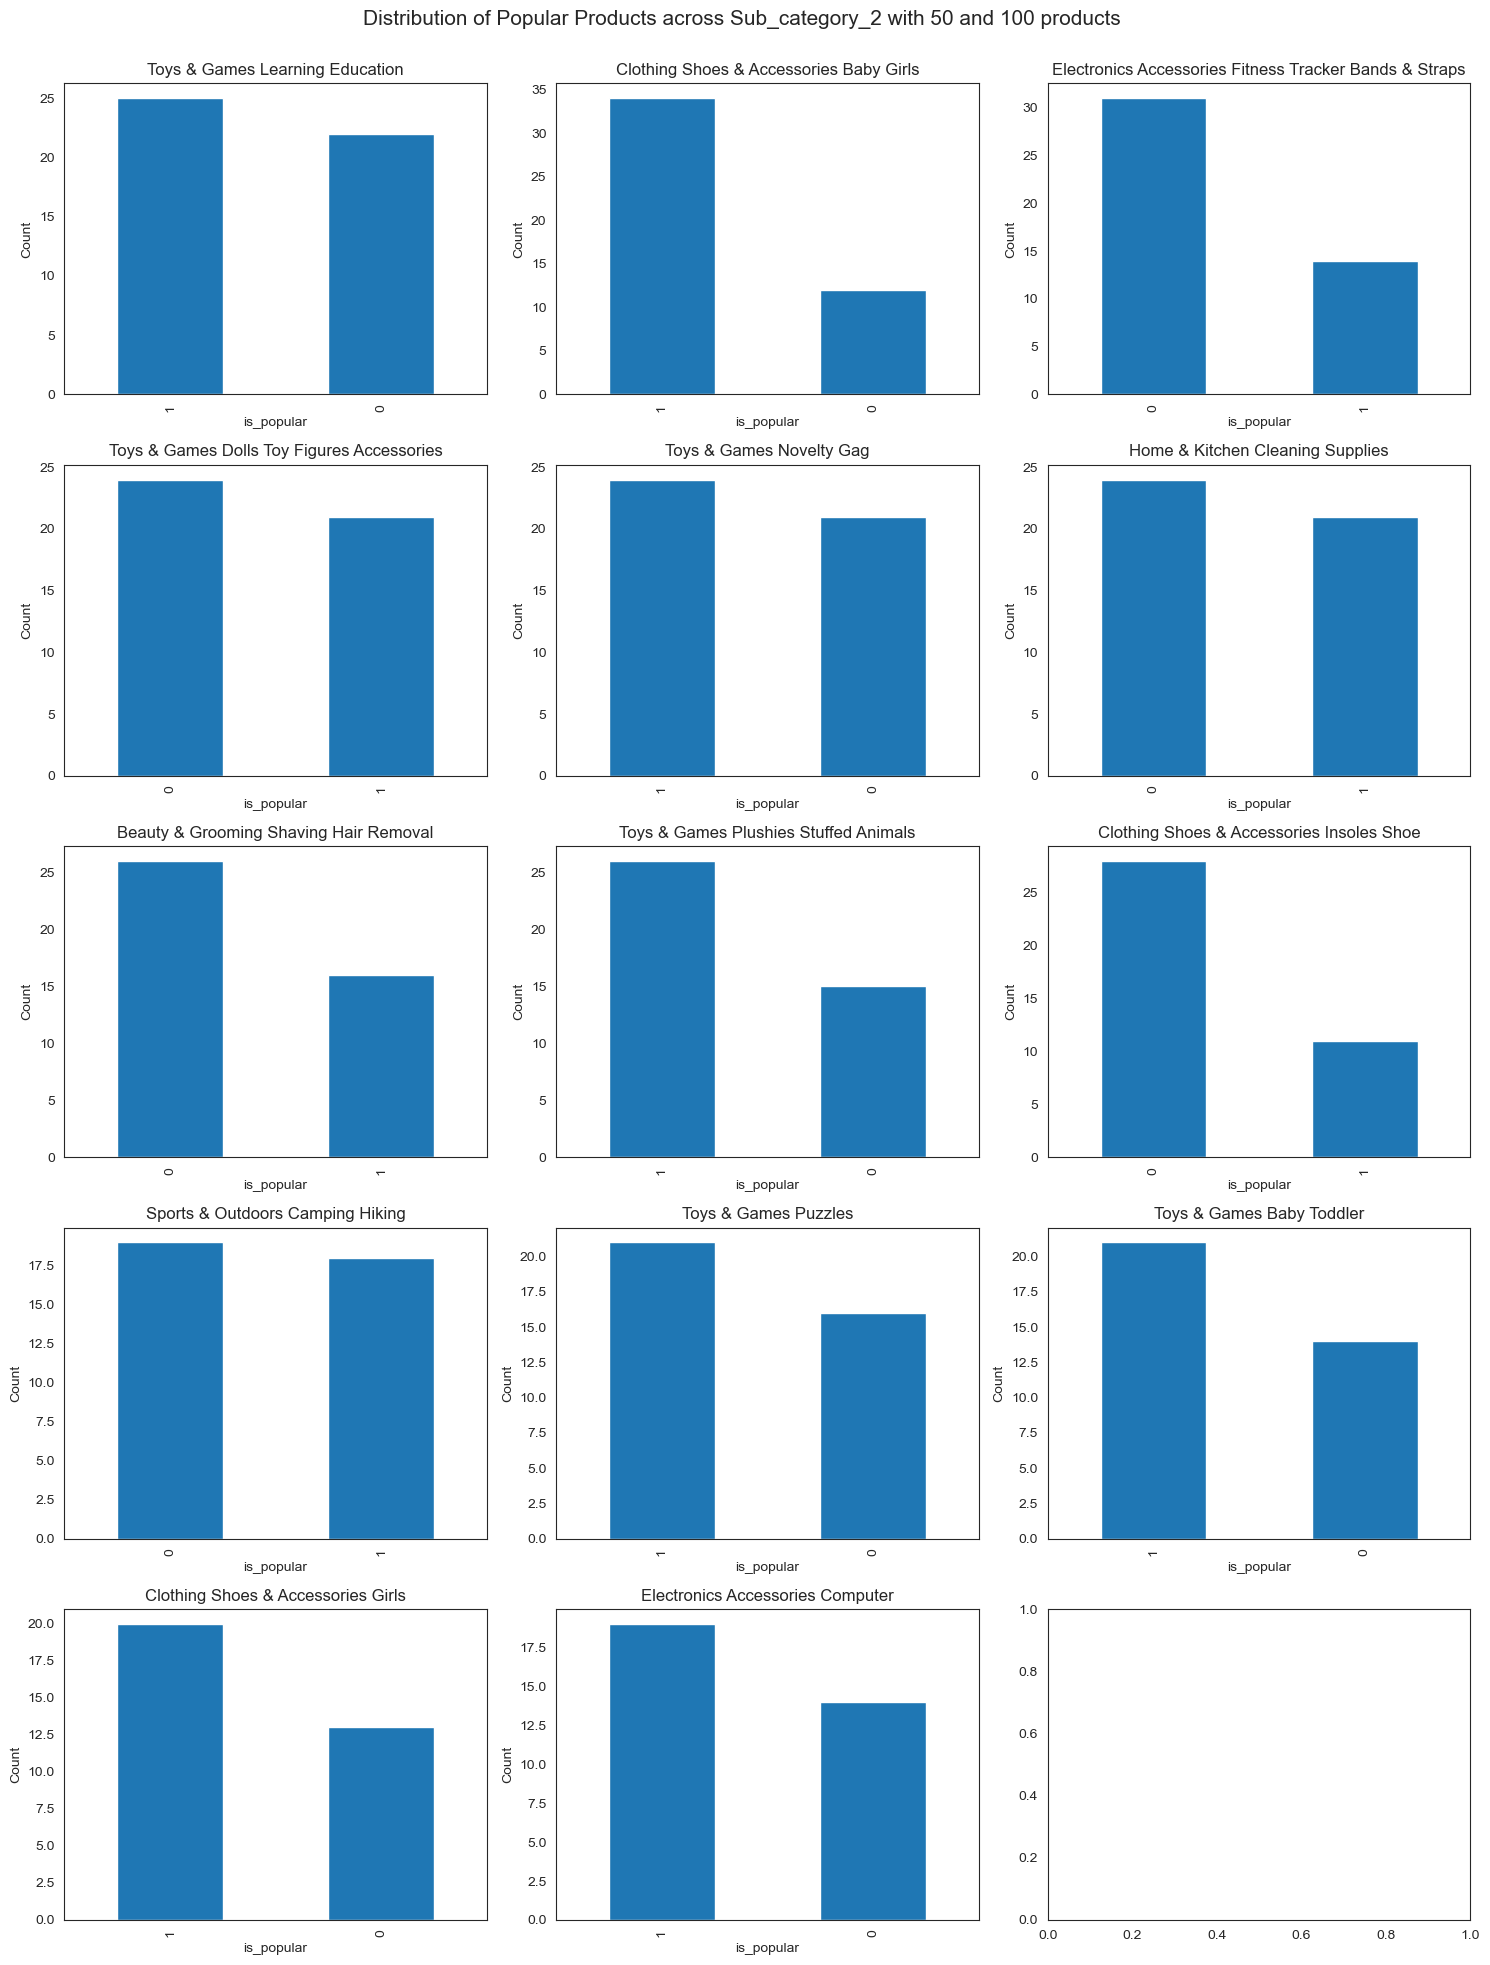

In [109]:
plt.subplots(5,3, figsize=(15,20))

for idx, subcat in enumerate(relevant_subcat): 

    plt.subplot(5, 3, idx+1) 

    # plot
    meta_df[meta_df['combined_category'] == subcat]['is_popular'].value_counts().plot(kind='bar')
    
    # add title + label
    plt.ylabel("Count")
    plt.title(f'{subcat}')

plt.suptitle("Distribution of Popular Products across Sub_category_2 with 50 and 100 products \n\n", fontsize=15)
plt.tight_layout()

plt.show()

In [110]:
print(f"There are {len(meta_df.groupby('combined_category')['is_popular'].agg(['mean', 'count']).loc[lambda x: x['mean'] < 0.5])} subcategories with higher proportion of unpopular products.")

There are 27 subcategories with higher proportion of unpopular products.


Some sub-categories have more popular items than others. Overall there are 27 categories with more unpopular products and popular products.

Now, lets create aggregated features by category similar to what we did for store.

#### <a id='toc1_1_10_1_'></a>[Aggregating ratings per combined-category](#toc0_)

In [111]:
#Create new columns that represents mean, std of ratings and product counts per combined category

#Calculate different metrics for sub_category_1
subcategory1_stats = meta_df.groupby('sub_category_1').agg(
    subcategory1_rating_mean=('bayesian_rating', 'mean'),
    subcategory1_rating_std=('bayesian_rating', 'std'),
)

# Merge the results back into meta_df
meta_df = meta_df.merge(subcategory1_stats, on='sub_category_1')

# Calculate different metrics for combined_category
combined_stats = meta_df.groupby('combined_category').agg(
    combined_category_rating_mean=('bayesian_rating', 'mean'),
    combined_category_product_counts=('bayesian_rating', 'size'),
    combined_category_rating_std=('bayesian_rating', 'std'),
)

# Merge the results back into meta_df
meta_df = meta_df.merge(combined_stats, on='combined_category')

In [112]:
#Apply log of product counts
meta_df['log_combined_category_product_counts'] = np.log1p(meta_df['combined_category_product_counts'])


# Coefficient of Variation (lower = more consistent ratings)
meta_df['subcategory1_rating_cv'] = meta_df['subcategory1_rating_std']/ meta_df['subcategory1_rating_mean']
meta_df['combined_category_rating_cv'] = meta_df['combined_category_rating_std']/ meta_df['combined_category_rating_mean']

#Target encoded features
cat_target_encode = meta_df.groupby('sub_category_1')["is_popular"].mean()
meta_df["subcategory1_target_encoded"] = meta_df['sub_category_1'].map(cat_target_encode)

cat_target_encode = meta_df.groupby('combined_category')["is_popular"].mean()
meta_df["combined_category_target_encoded"] = meta_df['combined_category'].map(cat_target_encode)


In [113]:
meta_df[['combined_category_product_counts','combined_category_rating_mean','combined_category_rating_std',
         'subcategory1_rating_mean','subcategory1_rating_std']].describe()

,combined_category_product_counts,combined_category_rating_mean,combined_category_rating_std,subcategory1_rating_mean,subcategory1_rating_std
count,38154.000000,38154.000000,38154.000000,38154.000000,38154.000000
mean,3607.828170,4.478005,0.139490,4.478005,0.142754
std,2558.880104,0.038511,0.017628,0.026931,0.010758
min,2.000000,4.288716,0.047168,4.386702,0.116130
25%,1428.000000,4.458650,0.134939,4.442259,0.138751
50%,3161.000000,4.488320,0.137408,4.495776,0.138751
75%,6006.000000,4.498132,0.140358,4.495776,0.155776
max,7350.000000,4.582536,0.246010,4.514073,0.174122


In [114]:
#Dropping original columns
meta_df.drop(columns=["sub_category_1","sub_category_2","sub_category_3","sub_category_4"],inplace=True)

#### <a id='toc1_1_10_2_'></a>[Checking Department column](#toc0_)

In [115]:
meta_df['department'].value_counts(dropna=False, normalize=True)

department
NaN       0.580280
women     0.247156
unisex    0.142868
men       0.026472
kids      0.002621
sports    0.000446
misc      0.000157
Name: proportion, dtype: float64

About 57% of the products don't have a department, we will drop this feature from modeling.

In [116]:
meta_df.drop(columns='department',inplace=True)

### <a id='toc1_1_11_'></a>[Pickling final dataframe](#toc0_)

In [117]:
meta_df.columns

Index(['title', 'average_rating', 'rating_number', 'price', 'store',
       'parent_asin', 'all_subcategories', 'date_first_available',
       'bayesian_rating', 'is_popular', 'num_product_images',
       'product_features', 'title_category', 'product_title_length',
       'is_generic_store', 'store_product_counts', 'log_store_product_counts',
       'store_rating_mean', 'store_rating_std', 'store_rating_cv',
       'store_size_tier', 'store_target_encoded', 'product_age_days',
       'is_weekend_release', 'log_price', 'combined_category',
       'subcategory1_rating_mean', 'subcategory1_rating_std',
       'combined_category_rating_mean', 'combined_category_product_counts',
       'combined_category_rating_std', 'log_combined_category_product_counts',
       'subcategory1_rating_cv', 'combined_category_rating_cv',
       'subcategory1_target_encoded', 'combined_category_target_encoded'],
      dtype='object')

In [118]:
print(f'The shape of the final pre-processed dataframe is {meta_df.shape}.')

The shape of the final pre-processed dataframe is (38154, 36).


In [119]:
# Check for nulls
meta_df.isna().sum().loc[lambda x: x>0]

Series([], dtype: int64)

In [120]:
#Rename columns
meta_df.rename(columns = {'price' :'product_price','title':'product_title'},inplace=True)

# Pickle the DataFrame for modeling
meta_df.to_pickle('../data/meta_sample_preprocessed.pkl')

### Data Dictionary

## Data Dictionary

| Column Name                             | Data Type     | Description |
|-----------------------------------------|--------------|-------------|
| **product_title**                       | object       | Title of the product. |
| **average_rating**                      | float64      | Average customer rating of the product. |
| **rating_number**                       | int64        | Total number of ratings received. |
| **product_price**                       | float64      | Price of the product. |
| **store**                                | object       | Name of the store selling the product. |
| **parent_asin**                          | object       | Parent ASIN identifier for the product. |
| **all_subcategories**                    | object       | All subcategories associated with the product. |
| **date_first_available**                 | datetime64   | Date when the product was first available on Amazon. |
| **bayesian_rating**                      | float64      | Adjusted rating using Bayesian averaging. |
| **is_popular**                           | int64        | Binary label indicating whether the product is popular (1) or not (0). |
| **num_product_images**                   | int64        | Number of product images available. |
| **product_features**                     | object       | Combined Text of product title, description and features. |
| **title_category**                       | object       | Combined title and category information. |
| **product_title_length**                 | int64        | Length of the product title in characters. |
| **is_generic_store**                     | int64        | Binary flag indicating whether the store name is generic or not. |
| **store_product_counts**                 | int64        | Number of products available in the store. |
| **log_store_product_counts**             | float64      | Log-transformed store product counts. |
| **store_rating_mean**                    | float64      | Mean Bayesian rating of all products in the store. |
| **store_rating_std**                     | float64      | Standard deviation of Bayesian product ratings in the store. |
| **store_rating_cv**                      | float64      | Coefficient of variation of Bayesian ratings in the store. |
| **store_size_tier**                      | object       | Categorization of store size based on number of products. |
| **store_target_encoded**                 | float64      | Target encoding applied to store column. |
| **product_age_days**                     | int64        | Age of the product in days since first availability. |
| **is_weekend_release**                   | int32        | Binary flag indicating whether the product was released on a weekend. |
| **log_price**                            | float64      | Log-transformed product price. |
| **combined_category**                    | object       | Combination of sub-category 1 and 2. |
| **subcategory1_rating_mean**             | float64      | Mean Bayesian rating of products in subcategory 1. |
| **subcategory1_rating_std**              | float64      | Standard deviation of Bayesian ratings in subcategory 1. |
| **combined_category_rating_mean**        | float64      | Mean Bayesian rating of products in the combined category. |
| **combined_category_product_counts**     | int64        | Number of products in the combined category. |
| **combined_category_rating_std**         | float64      | Standard deviation of Bayesian ratings in the combined category. |
| **log_combined_category_product_counts** | float64      | Log-transformed product count in the combined category. |
| **subcategory1_rating_cv**               | float64      | Coefficient of variation of Bayesian ratings in subcategory 1. |
| **combined_category_rating_cv**          | float64      | Coefficient of variation of ratings in the combined category. |
| **subcategory1_target_encoded**          | float64      | Target encoding applied to subcategory 1. |
| **combined_category_target_encoded**     | float64      | Target encoding applied to the combined category. |